# Import of libraries

In [377]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sweetviz as sv
import seaborn as sns
import warnings

from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import mean_squared_error
from natsort import natsorted
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor, RandomForestRegressor, AdaBoostClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from scipy.stats import chi2_contingency
from sklearn.decomposition import PCA

# Loading the data and preprocessing it

## Preprocessing functions called when loading the data

In [378]:
# Remove NaNs and unrealistic matches
def mark_invalid_team_rows(row):
    if row['HomeTeam'] == row['AwayTeam']:
        row['FTR'] = 'DELETE'
    elif pd.isna(row['HomeTeam']):
        row['FTR'] = 'DELETE'
    elif pd.isna(row['AwayTeam']):
        row['FTR'] = 'DELETE'
    return row

In [379]:
# Function that checks if columns are in the correct format
def check_and_convert(df):
    # List of column descriptions to exclude from conversion
    excluded_columns = [
        "Div","Date","Time",
        "HomeTeam","AwayTeam","FTHG","HG",
        "FTAG","AG",
        "FTR",
        "HTHG",
        "HTAG",
        "HTR"
    ]
    # Iterate over all columns in the DataFrame
    for column in df.columns:
        # If the column is not in the list of excluded columns
        if column not in excluded_columns:
            # Attempt to convert the column to float
            df[column] = pd.to_numeric(df[column], errors='coerce')
    # Return the modified DataFrame
    return df

In [380]:
# Remove unrealistic matches
def mark_for_deletion(row):
    if (row['FTHG'] + row['FTAG'] > 30) or (row['FTHG'] < 0) or (row['FTAG'] < 0):
        row['FTR'] = 'DELETE'
    elif pd.isna(row['FTHG']) and pd.isna(row['FTAG']) and pd.isna(row['FTR']):
        row['FTR'] = 'DELETE'
    elif pd.isna(row['FTR']) and (pd.isna(row['FTHG']) or pd.isna(row['FTAG'])):
        row['FTR'] = 'DELETE'
    return row

In [381]:
# Impute draws
def handle_draws(row):
    if row['FTR'] == 'D' and (pd.isna(row['FTHG']) or pd.isna(row['FTAG'])):
        # Set goals to 0 for a draw if either is missing
        row['FTHG'] = 0 if pd.isna(row['FTHG']) else row['FTHG']
        row['FTAG'] = 0 if pd.isna(row['FTAG']) else row['FTAG']
    return row


In [382]:
# Impute goal numbers based on results
def impute_goals_based_on_result(row):

    # Impute based on match result
    if row['FTR'] == 'A':
        if pd.isna(row['FTHG']) and pd.isna(row['FTAG']):
            row['FTHG'] = 0
            row['FTAG'] = 1
        elif pd.isna(row['FTHG']) and row['FTAG'] > 0:
            row['FTHG'] = row['FTAG'] - 1
        elif pd.isna(row['FTAG']):
            row['FTAG'] = row['FTHG'] + 1
    elif row['FTR'] == 'H':
        if pd.isna(row['FTHG']) and pd.isna(row['FTAG']):
            row['FTHG'] = 1
            row['FTAG'] = 0
        elif pd.isna(row['FTAG']) and row['FTHG'] > 0:
            row['FTAG'] = row['FTHG'] - 1
        elif pd.isna(row['FTHG']):
            row['FTHG'] = row['FTAG'] + 1

    return row

In [383]:
# Impute result based on number of goals
def impute_result_based_on_goals(row):
    if pd.isna(row['FTR']) and not pd.isna(row['FTHG']) and not pd.isna(row['FTAG']):
        if row['FTHG'] > row['FTAG']:
            row['FTR'] = 'H'
        elif row['FTHG'] < row['FTAG']:
            row['FTR'] = 'A'
        else:
            row['FTR'] = 'D'
    return row


In [384]:
# For feebback on imputed rows
def count_missing_values(row):
    return pd.isna(row['FTR']) or pd.isna(row['FTHG']) or pd.isna(row['FTAG'])

In [385]:
# For feebback on imputed rows
def count_alterations(original_df, modified_df, columns_to_check):
    return (original_df[columns_to_check] != modified_df[columns_to_check]).any(axis=1).sum()

### Table load

In [386]:
# This function loads countries data and uses tre preprocessing fucntions listed above
def load_data(country, num_files, remove_non_essential_columns = False, year_cutoff = 2018):

    # Accounting for England having league 0 - others skip it
    if country != "England": num_files = num_files + 1

    train_data = {}
    test_data = {}

    # Loading train data
    train_folder_paths = [f"train/{country}/{i}" for i in range(num_files)]
    for i, folder_path in enumerate(train_folder_paths):
        # Check if the path exists
        if os.path.exists(folder_path):
            file_list = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.csv')]
            train_data[i] = pd.concat([pd.read_csv(file) for file in file_list], ignore_index=True)

    train_data_combined = pd.concat(train_data.values(), ignore_index=True)
  
    # Loading test data
    test_folder_paths = [f"test/{country}/{i}" for i in range(num_files)]
    for i, folder_path in enumerate(test_folder_paths):
        # Check if the path exists
        if os.path.exists(folder_path):
            file_list = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.csv')]
            test_data[i] = pd.concat([pd.read_csv(file) for file in file_list], ignore_index=True)

    test_data_combined = pd.concat(test_data.values(), ignore_index=True)

    # Remove columns with only NAs
    test_data_combined = test_data_combined.dropna(axis=1, how='all')
    train_data_combined = train_data_combined.dropna(axis=1, how='all')

    if remove_non_essential_columns:
        # Remove surplus from train data and remove train colums that are only NAs
        # we are only interested in results and data that is in "test data" - we cannot use other columns
        test_columns = list(train_data_combined.columns.intersection(test_data_combined.columns))
        essential_columns = ['FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG', 'HTR'] 
        # Half time results removed as we see no use
        columns_to_keep = set(test_columns) | set(essential_columns)
        columns_to_drop = set(train_data_combined.columns) - set(columns_to_keep)
        # we use this backwards way to avoid reordering of columns
        train_data_combined = train_data_combined.drop(columns=columns_to_drop)


    # Change "Date" column to YYYY-MM-DD format
    # locally add [,format="mixed"] to fix the issue with dates
    if train_data_combined["Date"].any():
        train_data_combined["Date"] = pd.to_datetime(train_data_combined['Date'], format = "mixed").dt.date
    if test_data_combined["Date"].any():
        test_data_combined["Date"] = pd.to_datetime(test_data_combined['Date'], format = "mixed").dt.date

    # Delete old
    # older data has a much higher % of missing values + it is more relevant
    train_data_combined = train_data_combined[pd.to_datetime(train_data_combined['Date']).dt.year >= year_cutoff]
    
    # Print how many changes were made
    print(" ")
    print(f"Analyzing data for {country}")
    original_data_combined = train_data_combined.copy()
    total_rows = len(original_data_combined)
    missing_values_count = train_data_combined.apply(count_missing_values, axis=1).sum()
    print(f"Number of rows with missing values in FTR, FTHG, or FTAG for {country}: {missing_values_count}")
    
    # Apply and track changes for handle_draws
    before_draws = train_data_combined.copy()
    train_data_combined = train_data_combined.apply(handle_draws, axis=1)
    changed_by_draws = count_alterations(before_draws, train_data_combined, ['FTR', 'FTHG', 'FTAG'])
    print(f"Rows altered by handle_draws for {country}: {changed_by_draws} out of {total_rows}")

    # Apply and track changes for impute_goals_based_on_result
    before_goals_based_on_result = train_data_combined.copy()
    train_data_combined = train_data_combined.apply(impute_goals_based_on_result, axis=1)
    changed_by_goals_based_on_result = count_alterations(before_goals_based_on_result, train_data_combined, ['FTR', 'FTHG', 'FTAG'])
    print(f"Rows altered by impute_goals_based_on_result for {country}: {changed_by_goals_based_on_result} out of {total_rows}")

    # Apply and track changes for impute_result_based_on_goals
    before_result_based_on_goals = train_data_combined.copy()
    train_data_combined = train_data_combined.apply(impute_result_based_on_goals, axis=1)
    changed_by_result_based_on_goals = count_alterations(before_result_based_on_goals, train_data_combined, ['FTR', 'FTHG', 'FTAG'])
    print(f"Rows altered by impute_result_based_on_goals for {country}: {changed_by_result_based_on_goals} out of {total_rows}")
    
    
    train_data_combined = train_data_combined.apply(mark_for_deletion, axis=1)

    # Apply mark_invalid_team_rows function if it exists
    train_data_combined = train_data_combined.apply(mark_invalid_team_rows, axis=1)
    before_filtering = len(train_data_combined)
    train_data_combined = train_data_combined[train_data_combined['FTR'] != 'DELETE']
    after_filtering = len(train_data_combined)
    
    # Calculate and print the number of rows deleted and changed
    rows_deleted = before_filtering - after_filtering

    print(f"Number of rows deleted by match logic for {country}: {rows_deleted}")

    # Check if columns are in correct format
    check_and_convert(train_data_combined)
    check_and_convert(test_data_combined)  


    return train_data_combined, test_data_combined

### Loading of data call

In [387]:
# Load all countries - Country, number of leagues
germany_train_data, germany_test_data = load_data("Germany", 2)
belgium_train_data, belgium_test_data = load_data("Belgium", 1)
england_train_data, england_test_data = load_data("England", 4)
france_train_data, france_test_data = load_data("France", 2)
greece_train_data, greece_test_data = load_data("Greece", 1)
italy_train_data, italy_test_data = load_data("Italy", 2)
netherlands_train_data, netherlands_test_data = load_data("Netherlands", 1)
portugal_train_data, portugal_test_data = load_data("Portugal", 1)
scotland_train_data, scotland_test_data = load_data("Scotland", 4)
spain_train_data, spain_test_data = load_data("Spain", 2)
turkey_train_data, turkey_test_data = load_data("Turkey", 1)


 
Analyzing data for Germany
Number of rows with missing values in FTR, FTHG, or FTAG for Germany: 7
Rows altered by handle_draws for Germany: 7 out of 2693
Rows altered by impute_goals_based_on_result for Germany: 4 out of 2693
Rows altered by impute_result_based_on_goals for Germany: 0 out of 2693
Number of rows deleted by match logic for Germany: 9
 
Analyzing data for Belgium
Number of rows with missing values in FTR, FTHG, or FTAG for Belgium: 0
Rows altered by handle_draws for Belgium: 0 out of 1134
Rows altered by impute_goals_based_on_result for Belgium: 0 out of 1134
Rows altered by impute_result_based_on_goals for Belgium: 0 out of 1134
Number of rows deleted by match logic for Belgium: 4
 
Analyzing data for England
Number of rows with missing values in FTR, FTHG, or FTAG for England: 0
Rows altered by handle_draws for England: 0 out of 8623
Rows altered by impute_goals_based_on_result for England: 0 out of 8623
Rows altered by impute_result_based_on_goals for England: 0 out

# Data exploration

## Germany overview

In [388]:
germany_train_data.head(5)

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA,LB,LB.1,LB.2
5101,D1,2018-12-05,Leverkusen,Hannover,3.0,2.0,H,2.0,0.0,H,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5106,D1,2018-03-31,Hertha,Wolfsburg,0.0,0.0,D,0.0,0.0,D,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5108,D1,2018-03-02,Freiburg,Leverkusen,0.0,0.0,D,0.0,0.0,D,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5111,D1,2018-03-17,Ein Frankfurt,Mainz,3.0,0.0,H,3.0,0.0,H,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5114,D1,2018-10-02,Hannover,Freiburg,2.0,1.0,H,1.0,0.0,H,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [389]:
germany_test_data.head()

,Div,Date,Time,HomeTeam,AwayTeam,B365H,B365D,B365A,BWH,BWD,...,AvgC<2.5,AHCh,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA
0,D1,2022-05-08,19:30,Ein Frankfurt,Bayern Munich,6.00,5.00,1.50,5.75,4.8,...,3.03,1.25,2.00,1.93,2.00,1.93,2.01,2.00,1.93,1.94
1,D1,2022-06-08,14:30,Augsburg,Freiburg,3.30,3.50,2.15,3.30,3.4,...,1.95,0.25,2.04,1.89,2.04,1.88,2.08,1.89,2.03,1.84
2,D1,2022-06-08,14:30,Bochum,Mainz,3.20,3.40,2.20,3.10,3.4,...,1.97,0.25,1.95,1.98,1.95,1.97,1.99,1.99,1.93,1.93
3,D1,2022-06-08,14:30,M'gladbach,Hoffenheim,2.05,4.20,3.00,2.15,3.9,...,2.81,-0.50,2.06,1.87,2.08,1.85,2.10,1.88,2.04,1.84
4,D1,2022-06-08,14:30,Union Berlin,Hertha,1.72,3.75,4.50,1.78,3.6,...,1.92,-0.50,1.90,2.03,1.91,2.01,1.93,2.05,1.88,1.99


### Columns test x train

In [390]:
intersection_columns = germany_train_data.columns.intersection(germany_test_data.columns)

print(intersection_columns)

Index(['Div', 'Date', 'HomeTeam', 'AwayTeam', 'IWH', 'IWD', 'IWA', 'WHH',
       'WHD', 'WHA', 'B365H', 'B365D', 'B365A', 'B365>2.5', 'B365<2.5',
       'B365AHH', 'B365AHA', 'BWH', 'BWD', 'BWA', 'VCH', 'VCD', 'VCA', 'PSH',
       'PSD', 'PSA', 'PSCH', 'PSCD', 'PSCA', 'Time', 'MaxH', 'MaxD', 'MaxA',
       'AvgH', 'AvgD', 'AvgA', 'P>2.5', 'P<2.5', 'Max>2.5', 'Max<2.5',
       'Avg>2.5', 'Avg<2.5', 'AHh', 'PAHH', 'PAHA', 'MaxAHH', 'MaxAHA',
       'AvgAHH', 'AvgAHA', 'B365CH', 'B365CD', 'B365CA', 'BWCH', 'BWCD',
       'BWCA', 'IWCH', 'IWCD', 'IWCA', 'WHCH', 'WHCD', 'WHCA', 'VCCH', 'VCCD',
       'VCCA', 'MaxCH', 'MaxCD', 'MaxCA', 'AvgCH', 'AvgCD', 'AvgCA',
       'B365C>2.5', 'B365C<2.5', 'PC>2.5', 'PC<2.5', 'MaxC>2.5', 'MaxC<2.5',
       'AvgC>2.5', 'AvgC<2.5', 'AHCh', 'B365CAHH', 'B365CAHA', 'PCAHH',
       'PCAHA', 'MaxCAHH', 'MaxCAHA', 'AvgCAHH', 'AvgCAHA'],
      dtype='object')


In [391]:
difference_columns = germany_train_data.columns.symmetric_difference(germany_test_data.columns)

print(difference_columns)

Index(['ABP', 'AC', 'AF', 'AHW', 'AO', 'AR', 'AS', 'AST', 'AY', 'Attendance',
       'B365AH', 'BSA', 'BSD', 'BSH', 'Bb1X2', 'BbAH', 'BbAHh', 'BbAv<2.5',
       'BbAv>2.5', 'BbAvA', 'BbAvAHA', 'BbAvAHH', 'BbAvD', 'BbAvH', 'BbMx<2.5',
       'BbMx>2.5', 'BbMxA', 'BbMxAHA', 'BbMxAHH', 'BbMxD', 'BbMxH', 'BbOU',
       'FTAG', 'FTHG', 'FTR', 'GB<2.5', 'GB>2.5', 'GBA', 'GBAH', 'GBAHA',
       'GBAHH', 'GBD', 'GBH', 'HBP', 'HC', 'HF', 'HHW', 'HO', 'HR', 'HS',
       'HST', 'HTAG', 'HTHG', 'HTR', 'HY', 'LB', 'LB.1', 'LB.2', 'LBA', 'LBAH',
       'LBAHA', 'LBAHH', 'LBD', 'LBH', 'Referee', 'SBA', 'SBD', 'SBH', 'SJA',
       'SJD', 'SJH', 'SOA', 'SOD', 'SOH', 'SYA', 'SYD', 'SYH'],
      dtype='object')


### NA %, extreme outlier %

In [392]:
def summarize_dataframe(dataframe, missing_threshold=0.05, outlier_threshold=1.5):
    
    # Unlock display options
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)

    # Summary of missing values
    missing_percentages = dataframe.isnull().mean() * 100
    missing_columns = missing_percentages[missing_percentages > missing_threshold].index
    if not missing_columns.empty:
        print("Missing Values:")
        print(missing_percentages[missing_columns])

    # Summary of outliers in numeric columns using IQR method
    numeric_columns = dataframe.select_dtypes(include=[np.number]).columns
    print("\nOutliers:")
    for column in numeric_columns:
        q1 = dataframe[column].quantile(0.25)
        q3 = dataframe[column].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - outlier_threshold * iqr
        upper_bound = q3 + outlier_threshold * iqr

        outliers = dataframe[(dataframe[column] < lower_bound) | (dataframe[column] > upper_bound)]
        outlier_percentage = len(outliers) / len(dataframe) * 100
        
        if outlier_percentage > 0:
            print(f"{column}: {outlier_percentage:.2f}% outliers")

    # Reset display options to the default values
    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_columns')


summarize_dataframe(germany_train_data, missing_threshold=80, outlier_threshold=15)

Missing Values:
Attendance    100.000000
Referee       100.000000
HHW           100.000000
AHW           100.000000
HO            100.000000
AO            100.000000
HBP           100.000000
ABP           100.000000
GBH           100.000000
GBD           100.000000
GBA           100.000000
LBH            89.456036
LBD            89.456036
LBA            89.456036
SBH           100.000000
SBD           100.000000
SBA           100.000000
SYH           100.000000
SYD           100.000000
SYA           100.000000
SOH           100.000000
SOD           100.000000
SOA           100.000000
GB>2.5        100.000000
GB<2.5        100.000000
GBAHH         100.000000
GBAHA         100.000000
GBAH          100.000000
LBAHH         100.000000
LBAHA         100.000000
LBAH          100.000000
B365AH        100.000000
SJH           100.000000
SJD           100.000000
SJA           100.000000
BSH           100.000000
BSD           100.000000
BSA           100.000000
LB            100.000000
LB.1     

### Optical difference between majority NA and minority NA

In [393]:
df_na = germany_train_data[germany_train_data['AvgCA'].isna()]
df_not_na = germany_train_data[germany_train_data['AvgCA'].notna()]

In [394]:
#values that are majority NA
df_na

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA,LB,LB.1,LB.2
5101,D1,2018-12-05,Leverkusen,Hannover,3.0,2.0,H,2.0,0.0,H,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5106,D1,2018-03-31,Hertha,Wolfsburg,0.0,0.0,D,0.0,0.0,D,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5108,D1,2018-03-02,Freiburg,Leverkusen,0.0,0.0,D,0.0,0.0,D,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5111,D1,2018-03-17,Ein Frankfurt,Mainz,3.0,0.0,H,3.0,0.0,H,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5114,D1,2018-10-02,Hannover,Freiburg,2.0,1.0,H,1.0,0.0,H,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12296,D2,2018-03-08,Hamburg,Holstein Kiel,0.0,3.0,A,0.0,0.0,D,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12297,D2,2018-08-25,Magdeburg,Ingolstadt,1.0,1.0,D,1.0,1.0,D,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12298,D2,2018-09-11,Paderborn,Holstein Kiel,4.0,4.0,D,3.0,1.0,H,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12299,D2,2018-10-21,Regensburg,Darmstadt,1.0,1.0,D,0.0,1.0,A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [395]:
#values that are not majority NA
df_not_na

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA,LB,LB.1,LB.2
5701,D1,2020-06-27,M'gladbach,Hertha,2.0,1.0,H,1.0,0.0,H,...,1.96,1.95,1.96,2.00,2.05,1.93,1.95,NaN,NaN,NaN
5702,D1,2019-09-29,Fortuna Dusseldorf,Freiburg,1.0,2.0,A,1.0,1.0,D,...,1.67,2.24,1.72,2.28,1.83,2.21,1.72,NaN,NaN,NaN
5703,D1,2019-10-26,Freiburg,RB Leipzig,2.0,1.0,H,1.0,0.0,H,...,1.86,2.05,1.87,2.11,1.92,2.01,1.87,NaN,NaN,NaN
5704,D1,2019-09-14,RB Leipzig,Bayern Munich,1.0,1.0,D,1.0,1.0,D,...,1.88,2.06,1.86,2.09,2.01,2.00,1.89,NaN,NaN,NaN
5705,D1,2019-08-31,Wolfsburg,Paderborn,1.0,1.0,D,0.0,1.0,A,...,1.92,2.00,1.92,2.04,2.06,1.97,1.91,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13196,D2,2021-07-23,Schalke 04,Hamburg,1.0,3.0,A,1.0,0.0,H,...,1.95,1.92,1.99,1.98,2.04,1.88,1.96,NaN,NaN,NaN
13197,D2,2021-08-14,Sandhausen,Karlsruhe,0.0,0.0,D,0.0,0.0,D,...,1.80,2.07,1.85,2.13,1.86,2.04,1.80,NaN,NaN,NaN
13198,D2,2021-05-11,Holstein Kiel,Dresden,2.0,1.0,H,0.0,1.0,A,...,1.98,1.94,1.96,2.04,2.00,1.94,1.90,NaN,NaN,NaN
13199,D2,2021-10-17,Dresden,Nurnberg,0.0,1.0,A,0.0,1.0,A,...,1.83,2.06,1.85,2.11,1.90,2.03,1.83,NaN,NaN,NaN


# Baseline model - Classification

## Functions for baseline models

### Baseline DF

In [396]:
# Drop columns with missing values (NAs) from a DataFrame.
def drop_columns_with_na(df):
    return df.dropna(axis=1)

### Preprocessing for classification 

In [397]:
# Preprocesses dataframe for classification. Fill missing values, filter invalid data, create dummy variables, etc.
def preprocess(df, unique_team_names, train=True):

    df_copy = df.copy()
    
    if train:
        df_copy = df_copy[['Div', 'Date', 'HomeTeam', 'AwayTeam', 'FTR' ,'B365H', 'B365D', 'B365A']]
    else:
        df_copy = df_copy[['Div', 'Date', 'HomeTeam', 'AwayTeam', 'B365H', 'B365D', 'B365A']]

    # transform Date into epoch
    df_copy['Date'] = (pd.to_datetime(df_copy['Date']).astype('int64') / 10**11)

    # make column Div categorical
    df_copy['Div'] = df_copy['Div'].astype('category')

    if train:
        # Create dummy variables for each team from unique_team_names if 'HomeTeam' column exists
        if 'HomeTeam' in df_copy.columns:
            for team in unique_team_names:
                df_copy[f'HomeTeam_{team}'] = df_copy['HomeTeam'] == team
                df_copy[f'AwayTeam_{team}'] = df_copy['AwayTeam'] == team

    # Impute missing values in B365H based on HomeTeam
    df_copy['B365H'] = df_copy.groupby('HomeTeam')['B365H'].transform(lambda x: x.fillna(x.mean()))

    # Impute missing values in B365A based on AwayTeam
    df_copy['B365A'] = df_copy.groupby('AwayTeam')['B365A'].transform(lambda x: x.fillna(x.mean()))

    # Impute missing values in B365D based on HomeTeam and AwayTeam so that it does not depend on the order of teams
    df_copy['B365D'] = df_copy.groupby(['HomeTeam', 'AwayTeam'])['B365D'].transform(lambda x: x.fillna(x.mean()))
    df_copy['B365D'] = df_copy.groupby(['AwayTeam', 'HomeTeam'])['B365D'].transform(lambda x: x.fillna(x.mean()))

    # Impute missing values in B365H, B365D, B365A with overall mean
    df_copy['B365H'] = df_copy['B365H'].fillna(df_copy['B365H'].mean())
    df_copy['B365D'] = df_copy['B365D'].fillna(df_copy['B365D'].mean())
    df_copy['B365A'] = df_copy['B365A'].fillna(df_copy['B365A'].mean())

    return df_copy.reset_index(drop=True)


In [398]:
# Preprocesses test dataframe for classification. Fill missing values,filter invalid data, create dummy variables, etc.
def preprocess_test(df, unique_team_names):

    df_copy = df.copy()
    df_copy = df_copy[['Div', 'Date', 'HomeTeam', 'AwayTeam', 'B365H', 'B365D', 'B365A']]

    # transform Date into epoch
    df_copy['Date'] = (pd.to_datetime(df_copy['Date']).astype('int64') / 10**11)

    # make column Div categorical
    df_copy['Div'] = df_copy['Div'].astype('category')
    if 'HTR' in df_copy.columns:
        df_copy['HTR'] = df_copy['HTR'].astype('category')

    # create dummy variables for each team from unique_team_names
    for team in unique_team_names:
        df_copy[f'HomeTeam_{team}'] = df_copy['HomeTeam'] == team
        df_copy[f'AwayTeam_{team}'] = df_copy['AwayTeam'] == team

    # Handle missing values
    numerical_cols = df_copy.select_dtypes(include=['number']).columns
    categorical_cols = df_copy.select_dtypes(include=['category']).columns

    numerical_imputer = SimpleImputer(strategy='mean')
    categorical_imputer = SimpleImputer(strategy='most_frequent')

    df_copy[numerical_cols] = numerical_imputer.fit_transform(df_copy[numerical_cols])
    df_copy[categorical_cols] = categorical_imputer.fit_transform(df_copy[categorical_cols])

    return df_copy.reset_index(drop=True)

### Train-val-test split 

In [399]:
# Basic train/test split
def split_data(df, target_column, test_size=0.2, random_state=42):

    X = df.drop(target_column, axis=1)
    y = df[target_column]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    return X_train, X_test, y_train, y_test

In [400]:
# Old split with validation data
# def split_data(df, target_column, val_size=0.2, test_size=0.2, random_state=42):

#     X = df.drop(target_column, axis=1)
#     y = df[target_column]

#     # First, split into training and temporary (validation + test) sets
#     X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=(val_size + test_size), random_state=random_state)

#     # Then, split the temporary set into validation and test sets
#     X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=(test_size / (val_size + test_size)), random_state=random_state)

#     return X_train, X_val, X_test, y_train, y_val, y_test

In [401]:
# Chronological split (time based) with validation data
def chronological_split(df, target_column, date_column, val_size=0.2, test_size=0.2):

    # Check for the presence of the specified date column
    if date_column not in df.columns:
        raise ValueError(f"DataFrame must contain a '{date_column}' column")

    # Sort the DataFrame based on the specified date column
    df = df.sort_values(by=date_column)

    X = df.drop(target_column, axis=1)
    y = df[target_column]

    total_rows = len(df)
    train_size = 1 - (val_size + test_size)
    train_end_idx = int(total_rows * train_size)
    val_end_idx = train_end_idx + int(total_rows * val_size)

    X_train, y_train = X.iloc[:train_end_idx], y.iloc[:train_end_idx]
    X_val, y_val = X.iloc[train_end_idx:val_end_idx], y.iloc[train_end_idx:val_end_idx]
    X_test, y_test = X.iloc[val_end_idx:], y.iloc[val_end_idx:]

    return X_train, X_val, X_test, y_train, y_val, y_test

### Classifying features

In [402]:
# Classify features as numerical or categorical based on their data types.
def classify_features(df):

    numerical_features = []
    categorical_features = []
    
    for column in df.columns:
        if pd.api.types.is_numeric_dtype(df[column]):
            numerical_features.append(column)
        elif pd.api.types.is_categorical_dtype(df[column]):
            categorical_features.append(column)
    
    return numerical_features, categorical_features

### Random forest classifier

In [403]:
# Create a pipeline with a preprocessor and a Random Forest Classifier.
def create_model_pipeline(numerical_features, categorical_features, n_estimators=100, max_depth=5, random_state=0):

    # Create a preprocessor using ColumnTransformer and Pipeline
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', 'passthrough', numerical_features),
            ('cat', OneHotEncoder(), categorical_features)
        ])

    # Create a Random Forest Classifier
    rf_classifier = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=random_state)

    # Create a pipeline that combines the preprocessor and the classifier
    model = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', rf_classifier)])

    return model

### Evaluation function for classification

In [404]:
def evaluate_model(model, X, y):
    # Predictions on the validation set
    y_pred = model.predict(X)

    # F1 Score
    f1 = f1_score(y, y_pred, average='macro')  # 'weighted' for imbalanced classes
    print(f"F1 Score: {f1:.4f}")

    # Confusion Matrix
    conf_matrix = confusion_matrix(y, y_pred)
    print("\nConfusion Matrix:")
    print(conf_matrix)

#### F1 score

In [405]:
def F1_score_model(model, X, y):
    y_pred = model.predict(X)
    f1 = f1_score(y, y_pred, average='macro')
    return f1

### Saving predictions

In [406]:
# Saves the predictions on the test set to CSV files, divided by Div column.
def save_predictions(model, X_test, country_name, output_path = "predictions/class"):

    #Predictions on the test set
    y_pred_test = model.predict(X_test)

    # Create output directory if it doesn't exist
    os.makedirs(output_path, exist_ok=True)

    # Group by division
    grouped_by_div = X_test.groupby('Div')

    # Sort the divisions based on their numbers
    sorted_divisions = natsorted(grouped_by_div.groups.keys(), key=lambda x: int(''.join(filter(str.isdigit, x))))

    for division in sorted_divisions:
        # Extract features for the current division
        group_data = grouped_by_div.get_group(division)
        #X_test_div = group_data.drop('FTR', axis=1)

        # Predictions on the current division
        y_pred_test_div = model.predict(group_data)

        # Save predictions to CSV
        predictions_df = pd.DataFrame(y_pred_test_div)
        #predictions_df = predictions_df.iloc[1:]
        output_filename = f"{country_name}_{division[-1]}.csv"
        output_filepath = os.path.join(output_path, output_filename)
        predictions_df.to_csv(output_filepath, index=False, header=False)

## Baseline models of all countries

In [407]:
all_f1_scores = []

In [408]:
for country_name, country_train_data, country_test_data in [
    ('germany', germany_train_data, germany_test_data),
    ('belgium', belgium_train_data, belgium_test_data),
    ('england', england_train_data, england_test_data),
    ('france', france_train_data, france_test_data),
    ('greece', greece_train_data, greece_test_data),
    ('italy', italy_train_data, italy_test_data),
    ('netherlands', netherlands_train_data, netherlands_test_data),
    ('portugal', portugal_train_data, portugal_test_data),
    ('scotland', scotland_train_data, scotland_test_data),
    ('spain', spain_train_data, spain_test_data),
    ('turkey', turkey_train_data, turkey_test_data)
]:
    print(f"\nProcessing data for country: {country_name}")
    
    # Baseline dataset
    
    unique_team_names = set()

    unique_team_names = unique_team_names.union(set(country_train_data['AwayTeam'].unique()))

    # Preprocess data for the current country
    processed_data = preprocess(country_train_data, unique_team_names)

    # Split data into training and validation sets
    # X_train, X_val, X_test, y_train, y_val, y_test = chronological_split(processed_data, 'FTR', 'Date', val_size=0.2, test_size=0.2)
    #X_train, X_val, X_test, y_train, y_val, y_test = split_data(processed_data, 'FTR', val_size=0.2, test_size=0.2, random_state=42)
    X_train, X_test, y_train, y_test = split_data(processed_data, 'FTR', test_size=0.2, random_state=42)

    # Classify features for the current country
    numerical_features, categorical_features = classify_features(X_train)

    # Create the model pipeline
    model = create_model_pipeline(numerical_features, categorical_features)

    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Evaluate the model for the current country
    evaluate_model(model, X_test, y_test)
    all_f1_scores.append(F1_score_model(model, X_test, y_test))

    # Preprocess test data for the current country
    processed_data_test = preprocess_test(country_test_data, unique_team_names)

    # Save predictions on the test set
    save_predictions(model, processed_data_test, country_name, "predictions/class/baseline")




Processing data for country: germany
F1 Score: 0.3393

Confusion Matrix:
[[ 50   0 101]
 [ 26   0 110]
 [ 35   0 215]]

Processing data for country: belgium
F1 Score: 0.4248

Confusion Matrix:
[[52  0 20]
 [27  0 21]
 [28  0 78]]

Processing data for country: england
F1 Score: 0.3438

Confusion Matrix:
[[176   0 336]
 [ 98   0 338]
 [100   0 671]]

Processing data for country: france
F1 Score: 0.3553

Confusion Matrix:
[[ 85   2  90]
 [ 68   0 107]
 [ 59   0 217]]

Processing data for country: greece
F1 Score: 0.5020

Confusion Matrix:
[[35  9 12]
 [19  7 22]
 [19  3 86]]

Processing data for country: italy
F1 Score: 0.3777

Confusion Matrix:
[[109   0  84]
 [ 71   0 124]
 [ 57   0 222]]

Processing data for country: netherlands
F1 Score: 0.3695

Confusion Matrix:
[[32  0 38]
 [20  0 45]
 [20  0 99]]

Processing data for country: portugal
F1 Score: 0.4027

Confusion Matrix:
[[ 47   0  47]
 [ 14   0  52]
 [ 12   0 101]]

Processing data for country: scotland
F1 Score: 0.3952

Confusion

In [409]:
average_f1_score = sum(all_f1_scores) / len(all_f1_scores)
print(f"\nAverage F1 Score across countries: {average_f1_score:.4f}")


Average F1 Score across countries: 0.3819


# Baseline model - Regression

## Functions for Regression

### Preprocessing for regression

In [410]:
# Preprocesses dataframe for regression. Fill missing values,filter invalid data, create dummy variables, etc.
def preprocess_regression(df, train=True):

    df_copy = df.copy()
    
    # Feature selection
    selected_columns = ['Div', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'B365H', 'B365D', 'B365A', 'Max>2.5', 'Avg>2.5', 'Max<2.5', 'Avg<2.5']
    df_copy = df_copy[selected_columns]

    # Transform Date into epoch
    df_copy['Date'] = (pd.to_datetime(df_copy['Date']).astype('int64') / 10**11)

    # Make column 'Div' categorical
    df_copy['Div'] = df_copy['Div'].astype('category')
    
    # Create new feature 'goals' based on sum of 'FTHG' and 'FTAG'
    df_copy['goals'] = df_copy['FTHG'] + df_copy['FTAG']

    # Impute missing values in 'B365H' based on HomeTeam
    df_copy['B365H'] = df_copy.groupby('HomeTeam')['B365H'].transform(lambda x: x.fillna(x.mean()))

    # Impute missing values in 'B365A' based on AwayTeam
    df_copy['B365A'] = df_copy.groupby('AwayTeam')['B365A'].transform(lambda x: x.fillna(x.mean()))

    # Impute missing values in 'B365D' based on HomeTeam and AwayTeam
    df_copy['B365D'] = df_copy.groupby(['HomeTeam', 'AwayTeam'])['B365D'].transform(lambda x: x.fillna(x.mean()))
    df_copy['B365D'] = df_copy.groupby(['AwayTeam', 'HomeTeam'])['B365D'].transform(lambda x: x.fillna(x.mean()))

    # Impute missing values with overall mean
    columns_to_impute = ['B365H', 'B365D', 'B365A', 'Max>2.5', 'Max<2.5', 'Avg>2.5', 'Avg<2.5']
    for column in columns_to_impute:
        df_copy[column] = df_copy[column].fillna(df_copy[column].mean())

    # Drop unnecessary columns
    df_copy = df_copy.drop(['FTHG', 'FTAG', 'HomeTeam', 'AwayTeam'], axis=1, errors='ignore')
    
    #print("\nNumber of missing values after imputation:")
    #print(df_copy.isnull().sum())

    return df_copy.reset_index(drop=True)


In [411]:
# Preprocesses test dataframe for classification. Fill missing values, filter invalid data, create dummy variables, etc.
def preprocess_regression_test(df):

    df_copy = df.copy()
    selected_columns = ['Div', 'Date', 'HomeTeam', 'AwayTeam', 'B365H', 'B365D', 'B365A', 'Max>2.5', 'Avg>2.5', 'Max<2.5', 'Avg<2.5']
    df_copy = df_copy[selected_columns]

    # transform Date into epoch
    df_copy['Date'] = (pd.to_datetime(df_copy['Date']).astype('int64') / 10**11)

    # make column Div categorical
    df_copy['Div'] = df_copy['Div'].astype('category')

    # Impute missing values in 'B365H' based on HomeTeam
    df_copy['B365H'] = df_copy.groupby('HomeTeam')['B365H'].transform(lambda x: x.fillna(x.mean()))

    # Impute missing values in 'B365A' based on AwayTeam
    df_copy['B365A'] = df_copy.groupby('AwayTeam')['B365A'].transform(lambda x: x.fillna(x.mean()))

    # Impute missing values in 'B365D' based on HomeTeam and AwayTeam
    df_copy['B365D'] = df_copy.groupby(['HomeTeam', 'AwayTeam'])['B365D'].transform(lambda x: x.fillna(x.mean()))
    df_copy['B365D'] = df_copy.groupby(['AwayTeam', 'HomeTeam'])['B365D'].transform(lambda x: x.fillna(x.mean()))

    # Impute missing values with overall mean
    columns_to_impute = ['B365H', 'B365D', 'B365A', 'Max>2.5', 'Max<2.5', 'Avg>2.5', 'Avg<2.5']
    for column in columns_to_impute:
        df_copy[column] = df_copy[column].fillna(df_copy[column].mean())
        
    # Drop unnecessary columns
    df_copy = df_copy.drop(['HomeTeam', 'AwayTeam'], axis=1, errors='ignore')
    
    #print("\nNumber of missing values after imputation:")
    #print(df_copy.isnull().sum())

    return df_copy.reset_index(drop=True)

### Random forest regressor

In [412]:
# Create a pipeline with a preprocessor and a Random Forest Regressor.
def create_regressor_pipeline(numerical_features, categorical_features, n_estimators=500, max_depth=3, random_state=500):

    # Create a preprocessor using ColumnTransformer and Pipeline
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', 'passthrough', numerical_features),
            ('cat', OneHotEncoder(), categorical_features)
        ])

    # Create a Random Forest Regressor
    rf_regressor = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=random_state)

    # Create a pipeline that combines the preprocessor and the classifier
    model_rg = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', rf_regressor)])

    return model_rg

### Evaluation

In [413]:
# Calculate and print the Root Mean Squared Error (RMSE).
def rmse(model, X, y):

    y_pred = model_reg.predict(X)

    rmse = mean_squared_error(y, y_pred, squared=False)
    print('RMSE: {:.3f}'.format(rmse))
    return rmse

### Saving predictions

In [414]:
# Saves the predictions on the test set to CSV files, divided by Div column.
def save_predictions_reg(model, X_test, country_name, output_path = 'predictions/reg'):

    #Predictions on the test set
    y_pred_test = model.predict(X_test)

    # Create output directory if it doesn't exist
    os.makedirs(output_path, exist_ok=True)

    # Group by division
    grouped_by_div = X_test.groupby('Div')

    # Sort the divisions based on their numbers
    sorted_divisions = natsorted(grouped_by_div.groups.keys(), key=lambda x: int(''.join(filter(str.isdigit, x))))

    for division in sorted_divisions:
        # Extract features for the current division
        group_data = grouped_by_div.get_group(division)
        #X_test_div = group_data.drop('FTR', axis=1)

        # Predictions on the current division
        y_pred_test_div = model.predict(group_data)
        rounded_y_pred_test_div = np.round(y_pred_test_div, 0).astype(int)

        # Save predictions to CSV
        predictions_df = pd.DataFrame(rounded_y_pred_test_div)
        #predictions_df = predictions_df.iloc[1:]
        output_filename = f"{country_name}_{division[-1]}.csv"
        output_filepath = os.path.join(output_path, output_filename)
        predictions_df.to_csv(output_filepath, index=False, header=False)

In [415]:
## Baseline models for all countries
all_rmse = []

In [416]:
for country_name, country_train_data, country_test_data in [
    ('germany', germany_train_data, germany_test_data),
    ('belgium', belgium_train_data, belgium_test_data),
    ('england', england_train_data, england_test_data),
    ('france', france_train_data, france_test_data),
    ('greece', greece_train_data, greece_test_data),
    ('italy', italy_train_data, italy_test_data),
    ('netherlands', netherlands_train_data, netherlands_test_data),
    ('portugal', portugal_train_data, portugal_test_data),
    ('scotland', scotland_train_data, scotland_test_data),
    ('spain', spain_train_data, spain_test_data),
    ('turkey', turkey_train_data, turkey_test_data)
]:
    print(f"\nProcessing data for country: {country_name}")
    

    # Preprocess data for the current country
    processed_data_reg = preprocess_regression(country_train_data)

    # Split data into training and validation sets
    X_train, X_val, X_test, y_train, y_val, y_test = chronological_split(processed_data_reg, 'goals', 'Date', val_size=0.2, test_size=0.2)
    #X_train, X_val, X_test, y_train, y_val, y_test = split_data(processed_data, 'FTR', val_size=0.2, test_size=0.2, random_state=42)
    
    #Imputing mean 
    y_train = y_train.fillna(y_train.mean())
    y_val = y_val.fillna(y_val.mean())
    y_test = y_test.fillna(y_test.mean())

    
    # Classify features for the current country
    numerical_features, categorical_features = classify_features(X_train)

    # Create the model pipeline
    model_reg = create_regressor_pipeline(numerical_features, categorical_features)

    # Fit the model on the training data
    model_reg.fit(X_train, y_train)

    # Evaluate the model for the current country
    #rmse(model_reg, X_val, y_val)
    all_rmse.append(rmse(model_reg, X_val, y_val))

    # Preprocess test data for the current country
    processed_data_test = preprocess_regression_test(country_test_data)

    # Save predictions on the test set
    #save_predictions_reg(model_reg, processed_data_test, country_name, predictions/class/base)




Processing data for country: germany
RMSE: 1.606

Processing data for country: belgium
RMSE: 1.609

Processing data for country: england
RMSE: 1.578

Processing data for country: france
RMSE: 1.571

Processing data for country: greece
RMSE: 1.566

Processing data for country: italy
RMSE: 1.630

Processing data for country: netherlands
RMSE: 1.682

Processing data for country: portugal
RMSE: 1.470

Processing data for country: scotland
RMSE: 1.564

Processing data for country: spain
RMSE: 1.428

Processing data for country: turkey
RMSE: 1.751


In [417]:
average_rmse = sum(all_rmse) / len(all_rmse)
print(f"\nAverage RMSE: {average_rmse:.4f}")


Average RMSE: 1.5870


# Feature engineering 

- [X] **Create additional features based on historical match statistics.** 
  - [x] **Average Goals:** Calculate the average number of goals scored and conceded by each team over a certain window of past matches.
  - [x] **Winning Streak:** Track the number of consecutive wins or losses for each team.
  - [x] **Goal Difference:** Compute the goal difference for each team, indicating the relative strength of their offense and defense.
  - [x] **Hypothesis:** if a team scored more than 2.5 goals in the past, it is more likely to score more than 2.5 goals in the next match ratio of home/away team over 2.5 goals in the all matches from trainig data
  
- [X] **Use Lag Features:**
  - Introduce lag features to represent the outcome of previous matches. For example, include the result (win, lose, draw) or the goal difference of the last encounter between two teams.

- [x] **Correlations with Match Outcomes:**
  - [x] Examine the correlation between certain odds features and actual match outcomes. Certain odds patterns or behaviors might be indicative of future results. Use the average of these odds which will get most relevant outcomes. We need at least one feature with odds for H/A/D and one for number of goals 
  - [ ] **Hypothesis**: if a team is a favourite, it is more likely to win the match by a larger margin. True if difference between home and away team odds is more than 3.


- [ ] **AVG ods**

#### load data with all original columns

In [418]:
# load with additional columns

# Run time ~10 minutes on cloud (locally < 10s)
# Load all countries - Country, number of leagues

germany_all_train_data, germany_all_test_data = load_data("Germany", 2, True)
belgium_all_train_data, belgium_all_test_data = load_data("Belgium", 1, True)
england_all_train_data, england_all_test_data = load_data("England", 4, True)
france_all_train_data, france_all_test_data = load_data("France", 2, True)
greece_all_train_data, greece_all_test_data = load_data("Greece", 1, True)
italy_all_train_data, italy_all_test_data = load_data("Italy", 2, True)
netherlands_all_train_data, netherlands_all_test_data = load_data("Netherlands", 1, True)
portugal_all_train_data, portugal_all_test_data = load_data("Portugal", 1, True)
scotland_all_train_data, scotland_all_test_data = load_data("Scotland", 4, True)
spain_all_train_data, spain_all_test_data = load_data("Spain", 2, True)
turkey_all_train_data, turkey_all_test_data = load_data("Turkey", 1, True)

 
Analyzing data for Germany
Number of rows with missing values in FTR, FTHG, or FTAG for Germany: 7
Rows altered by handle_draws for Germany: 7 out of 2693
Rows altered by impute_goals_based_on_result for Germany: 4 out of 2693
Rows altered by impute_result_based_on_goals for Germany: 0 out of 2693
Number of rows deleted by match logic for Germany: 9
 
Analyzing data for Belgium
Number of rows with missing values in FTR, FTHG, or FTAG for Belgium: 0
Rows altered by handle_draws for Belgium: 0 out of 1134
Rows altered by impute_goals_based_on_result for Belgium: 0 out of 1134
Rows altered by impute_result_based_on_goals for Belgium: 0 out of 1134
Number of rows deleted by match logic for Belgium: 4
 
Analyzing data for England
Number of rows with missing values in FTR, FTHG, or FTAG for England: 0
Rows altered by handle_draws for England: 0 out of 8623
Rows altered by impute_goals_based_on_result for England: 0 out of 8623
Rows altered by impute_result_based_on_goals for England: 0 out

## train

In [419]:
# function to call all train datasets for feature addition

def call_countries_all_train(function):

    warnings.filterwarnings('ignore')
    
    # List of dataset names
    dataset_names = [
    'germany_all_train_data',
    'belgium_all_train_data',
    'england_all_train_data',
    'france_all_train_data',
    'greece_all_train_data',
    'italy_all_train_data',
    'netherlands_all_train_data',
    'portugal_all_train_data',
    'scotland_all_train_data',
    'spain_all_train_data',
    'turkey_all_train_data' 
    ]
    # Process each dataset and store the result in a dictionary
    for name in dataset_names:
            # globals() to access these datasets by name
        dataset = globals().get(name)
        if dataset is not None:
            function(dataset)
            print(f"Dataset {name} OK")
        else:
            print(f"Dataset {name} not found.")

    return print("Done :)")

#### Lagged H2H

In [420]:
# Update the DataFrame with the lagged head-to-head result, considering home and away swaps.
def lagged_h2h_result(df):

    # Create a unique key for each match (sorted pair of HomeTeam and AwayTeam)
    df['MatchKey'] = df.apply(lambda row: tuple(sorted([row['HomeTeam'], row['AwayTeam']])), axis=1)

    # Initialize a dictionary to store the last result of each match pair
    last_match_results = {}

    # Initialize a column for lagged head-to-head result
    df['LaggedH2HResult'] = 2

    # Iterate over the rows in the DataFrame
    for index, row in df.iterrows():
        match_key = row['MatchKey']

        # If the match pair exists in the dictionary, retrieve the last result
        if match_key in last_match_results:
            df.at[index, 'LaggedH2HResult'] = last_match_results[match_key]
           

        # Update the last result for this match pair
        # Reverse the result if the home team of the current match was the away team in the previous match
        reversed_result = 'A' if row['FTR'] == 'H' else 'H' if row['FTR'] == 'A' else 'D'
        last_match_results[match_key] = reversed_result


        ## to 0-1-2
        if last_match_results[match_key] == "H": 
            last_match_results[match_key] = 0
        elif last_match_results[match_key] == "A": 
            last_match_results[match_key] = 1
        else:
            last_match_results[match_key] = 2

    # Remove the temporary 'MatchKey' column
    df.drop('MatchKey', axis=1, inplace=True)

    return df

call_countries_all_train(lagged_h2h_result)

Dataset germany_all_train_data OK
Dataset belgium_all_train_data OK
Dataset england_all_train_data OK
Dataset france_all_train_data OK
Dataset greece_all_train_data OK
Dataset italy_all_train_data OK
Dataset netherlands_all_train_data OK
Dataset portugal_all_train_data OK
Dataset scotland_all_train_data OK
Dataset spain_all_train_data OK
Dataset turkey_all_train_data OK
Done :)


#### avg goals per team (lagged)

In [421]:
# Calculate the lagged average of final goals for each team in the dataset.
def calculate_lagged_goals_average(df):

    # Initialize dictionaries to store the sum of goals and the count of matches for each team
    sum_goals = {}
    match_count = {}

    # Initialize columns for lagged average goals
    df['AvgHomeGoals'] = 0.0
    df['AvgAwayGoals'] = 0.0

    # Iterate over the rows in the DataFrame
    for index, row in df.iterrows():
        home_team = row['HomeTeam']
        away_team = row['AwayTeam']
        home_goals = row['FTHG']
        away_goals = row['FTAG']

        # Calculate lagged average goals for home team
        if home_team in sum_goals and match_count[home_team] > 0:
            df.at[index, 'AvgHomeGoals'] = sum_goals[home_team] / match_count[home_team]
        else:
            df.at[index, 'AvgHomeGoals'] = home_goals

        # Update sum_goals and match_count for home team
        sum_goals[home_team] = sum_goals.get(home_team, 0) + home_goals
        match_count[home_team] = match_count.get(home_team, 0) + 1

        # Calculate lagged average goals for away team
        if away_team in sum_goals and match_count[away_team] > 0:
            df.at[index, 'AvgAwayGoals'] = sum_goals[away_team] / match_count[away_team]
        else:
            df.at[index, 'AvgAwayGoals'] = away_goals

        # Update sum_goals and match_count for away team
        sum_goals[away_team] = sum_goals.get(away_team, 0) + away_goals
        match_count[away_team] = match_count.get(away_team, 0) + 1

    return df

call_countries_all_train(calculate_lagged_goals_average)

Dataset germany_all_train_data OK
Dataset belgium_all_train_data OK
Dataset england_all_train_data OK
Dataset france_all_train_data OK
Dataset greece_all_train_data OK
Dataset italy_all_train_data OK
Dataset netherlands_all_train_data OK
Dataset portugal_all_train_data OK
Dataset scotland_all_train_data OK
Dataset spain_all_train_data OK
Dataset turkey_all_train_data OK
Done :)


In [422]:
# check on one example if the logic is sound
bayern_matches = germany_all_train_data[(germany_all_train_data['HomeTeam'] == 'Bayern Munich') |
                                               (germany_all_train_data['AwayTeam'] == 'Bayern Munich')]

bayern_matches[['Date', 'HomeTeam', 'AwayTeam', 'FTR', 'FTHG', 'FTAG',  'AvgHomeGoals', 'AvgAwayGoals']]

,Date,HomeTeam,AwayTeam,FTR,FTHG,FTAG,AvgHomeGoals,AvgAwayGoals
5115,2018-10-03,Bayern Munich,Hamburg,H,6.0,0.0,6.000000,0.000000
5160,2018-04-03,Freiburg,Bayern Munich,A,0.0,4.0,0.500000,6.000000
5161,2018-12-01,Leverkusen,Bayern Munich,A,1.0,3.0,1.400000,5.000000
5168,2018-10-02,Bayern Munich,Schalke 04,H,2.0,1.0,4.333333,1.400000
5176,2018-01-21,Bayern Munich,Werder Bremen,H,4.0,2.0,3.750000,1.000000
...,...,...,...,...,...,...,...,...
6565,2021-12-17,Bayern Munich,Wolfsburg,H,4.0,0.0,2.904762,1.464789
6579,2022-08-05,Bayern Munich,Stuttgart,D,2.0,2.0,2.912162,1.278261
6589,2021-11-12,Bayern Munich,Mainz,H,2.0,1.0,2.906040,1.294521
6594,2022-05-14,Wolfsburg,Bayern Munich,D,2.0,2.0,1.448980,2.900000


#### % of goals > 2.5 per team

In [423]:
def fraction_over_2_goals(df):
    """
    Calculate the lagged fraction of games where each team scored over 2 goals in the dataset.
    If there's no history, the fraction will be based on the current match.

    :param df: DataFrame containing the match data.
    :return: DataFrame with additional columns for the lagged fraction of games scoring over 2 goals.
    """
    # Initialize dictionaries to store the count of matches and matches scoring over 2 goals for each team
    total_matches = {}
    matches_scoring_over_2 = {}

    # Initialize columns for the lagged fraction of games scoring over 2 goals
    df['Over2GoalsHome'] = 0.0
    df['Over2GoalsAway'] = 0.0

    # Iterate over the rows in the DataFrame
    for index, row in df.iterrows():
        home_team = row['HomeTeam']
        away_team = row['AwayTeam']
        home_goals = row['FTHG']
        away_goals = row['FTAG']

        # Calculate lagged fractions for home team
        if home_team in total_matches:
            df.at[index, 'Over2GoalsHome'] = matches_scoring_over_2.get(home_team, 0) / total_matches[home_team]
        else:
            df.at[index, 'Over2GoalsHome'] = 1 if home_goals > 2 else 0

        # Calculate lagged fractions for away team
        if away_team in total_matches:
            df.at[index, 'Over2GoalsAway'] = matches_scoring_over_2.get(away_team, 0) / total_matches[away_team]
        else:
            df.at[index, 'Over2GoalsAway'] = 1 if away_goals > 2 else 0

        # Update counters for next iteration
        total_matches[home_team] = total_matches.get(home_team, 0) + 1
        total_matches[away_team] = total_matches.get(away_team, 0) + 1
        if home_goals > 2:
            matches_scoring_over_2[home_team] = matches_scoring_over_2.get(home_team, 0) + 1
        if away_goals > 2:
            matches_scoring_over_2[away_team] = matches_scoring_over_2.get(away_team, 0) + 1

    return df

call_countries_all_train(fraction_over_2_goals)

Dataset germany_all_train_data OK
Dataset belgium_all_train_data OK
Dataset england_all_train_data OK
Dataset france_all_train_data OK
Dataset greece_all_train_data OK
Dataset italy_all_train_data OK
Dataset netherlands_all_train_data OK
Dataset portugal_all_train_data OK
Dataset scotland_all_train_data OK
Dataset spain_all_train_data OK
Dataset turkey_all_train_data OK
Done :)


In [424]:
# check on one example if the logic is sound
bayern_hertha_matches = germany_all_train_data[(germany_all_train_data['HomeTeam'] == 'Bayern Munich') |
                                               (germany_all_train_data['AwayTeam'] == 'Bayern Munich')]

bayern_hertha_matches[['Date', 'HomeTeam', 'AwayTeam', 'FTR', 'FTHG', 'FTAG',  'Over2GoalsHome', 'Over2GoalsAway']]

,Date,HomeTeam,AwayTeam,FTR,FTHG,FTAG,Over2GoalsHome,Over2GoalsAway
5115,2018-10-03,Bayern Munich,Hamburg,H,6.0,0.0,1.000000,0.000000
5160,2018-04-03,Freiburg,Bayern Munich,A,0.0,4.0,0.000000,1.000000
5161,2018-12-01,Leverkusen,Bayern Munich,A,1.0,3.0,0.200000,1.000000
5168,2018-10-02,Bayern Munich,Schalke 04,H,2.0,1.0,1.000000,0.000000
5176,2018-01-21,Bayern Munich,Werder Bremen,H,4.0,2.0,0.750000,0.000000
...,...,...,...,...,...,...,...,...
6565,2021-12-17,Bayern Munich,Wolfsburg,H,4.0,0.0,0.578231,0.169014
6579,2022-08-05,Bayern Munich,Stuttgart,D,2.0,2.0,0.581081,0.121739
6589,2021-11-12,Bayern Munich,Mainz,H,2.0,1.0,0.577181,0.164384
6594,2022-05-14,Wolfsburg,Bayern Munich,D,2.0,2.0,0.163265,0.573333


#### Streak

In [425]:
# Calculate a lagged win streak counter for each team in the dataset, considering both wins and losses.
def streak(df):

    # Initialize a dictionary to store the current streak of each team
    team_streaks = {}

    # Initialize columns for the lagged win streak
    df['StreakHome'] = 0
    df['StreakAway'] = 0

    # Iterate over the rows in the DataFrame
    for index, row in df.iterrows():
        home_team = row['HomeTeam']
        away_team = row['AwayTeam']
        result = row['FTR']

        # Update the lagged streak for home team
        df.at[index, 'StreakHome'] = team_streaks.get(home_team, 0)

        # Update the lagged streak for away team
        df.at[index, 'StreakAway'] = team_streaks.get(away_team, 0)

        # Update the current streak for home team
        if result == 'H':  # Home win
            team_streaks[home_team] = max(team_streaks.get(home_team, 0) + 1, 1)  # Reset negative streak if any
            team_streaks[away_team] = min(team_streaks.get(away_team, 0) - 1, -1) # Start or extend negative streak
        elif result == 'A':  # Away win
            team_streaks[away_team] = max(team_streaks.get(away_team, 0) + 1, 1)
            team_streaks[home_team] = min(team_streaks.get(home_team, 0) - 1, -1)
        # Draws do not affect the streak

    return df

call_countries_all_train(streak)


Dataset germany_all_train_data OK
Dataset belgium_all_train_data OK
Dataset england_all_train_data OK
Dataset france_all_train_data OK
Dataset greece_all_train_data OK
Dataset italy_all_train_data OK
Dataset netherlands_all_train_data OK
Dataset portugal_all_train_data OK
Dataset scotland_all_train_data OK
Dataset spain_all_train_data OK
Dataset turkey_all_train_data OK
Done :)


In [426]:
# check on one example if the logic is sound
bayern_matches = germany_all_train_data[(germany_all_train_data['HomeTeam'] == 'Bayern Munich') |
                                               (germany_all_train_data['AwayTeam'] == 'Bayern Munich')]

bayern_matches[['Date', 'HomeTeam', 'AwayTeam', 'FTR', 'FTHG', 'FTAG',  'StreakHome', 'StreakAway']]

,Date,HomeTeam,AwayTeam,FTR,FTHG,FTAG,StreakHome,StreakAway
5115,2018-10-03,Bayern Munich,Hamburg,H,6.0,0.0,0,0
5160,2018-04-03,Freiburg,Bayern Munich,A,0.0,4.0,-3,1
5161,2018-12-01,Leverkusen,Bayern Munich,A,1.0,3.0,1,2
5168,2018-10-02,Bayern Munich,Schalke 04,H,2.0,1.0,3,2
5176,2018-01-21,Bayern Munich,Werder Bremen,H,4.0,2.0,4,1
...,...,...,...,...,...,...,...,...
6565,2021-12-17,Bayern Munich,Wolfsburg,H,4.0,0.0,11,-1
6579,2022-08-05,Bayern Munich,Stuttgart,D,2.0,2.0,12,1
6589,2021-11-12,Bayern Munich,Mainz,H,2.0,1.0,12,1
6594,2022-05-14,Wolfsburg,Bayern Munich,D,2.0,2.0,-1,13


#### GRatio

In [427]:
# Calculate a lagged ratio of goals received to goals given for each team in the dataset.
def goals_ratio(df):

    # Initialize dictionaries to store the sum of goals scored and conceded for each team
    goals_scored = {}
    goals_conceded = {}

    # Initialize columns for the lagged ratio of goals
    df['GRatioHome'] = 0.0
    df['GRatioAway'] = 0.0

    # Iterate over the rows in the DataFrame
    for index, row in df.iterrows():
        home_team = row['HomeTeam']
        away_team = row['AwayTeam']
        home_goals = row['FTHG']
        away_goals = row['FTAG']

        # Update the lagged ratio for home team
        if home_team in goals_scored:
            if goals_conceded.get(home_team, 1) > 0:
                df.at[index, 'GRatioHome'] = goals_scored[home_team] / goals_conceded[home_team]
            else:
                df.at[index, 'GRatioHome'] = goals_scored[home_team]  # Handle division by zero
        else:
            df.at[index, 'GRatioHome'] = 0

        # Update the lagged ratio for away team
        if away_team in goals_scored:
            if goals_conceded.get(away_team, 1) > 0:
                df.at[index, 'GRatioAway'] = goals_scored[away_team] / goals_conceded[away_team]
            else:
                df.at[index, 'GRatioAway'] = goals_scored[away_team]  # Handle division by zero
        else:
            df.at[index, 'GRatioAway'] = 0

        # Update goals scored and conceded for next iteration
        goals_scored[home_team] = goals_scored.get(home_team, 0) + home_goals
        goals_conceded[home_team] = goals_conceded.get(home_team, 0) + away_goals
        goals_scored[away_team] = goals_scored.get(away_team, 0) + away_goals
        goals_conceded[away_team] = goals_conceded.get(away_team, 0) + home_goals

    return df

call_countries_all_train(goals_ratio)


Dataset germany_all_train_data OK
Dataset belgium_all_train_data OK
Dataset england_all_train_data OK
Dataset france_all_train_data OK
Dataset greece_all_train_data OK
Dataset italy_all_train_data OK
Dataset netherlands_all_train_data OK
Dataset portugal_all_train_data OK
Dataset scotland_all_train_data OK
Dataset spain_all_train_data OK
Dataset turkey_all_train_data OK
Done :)


In [428]:
# check on one example if the logic is sound
bayern_matches = germany_all_train_data[(germany_all_train_data['HomeTeam'] == 'Bayern Munich') |
                                               (germany_all_train_data['AwayTeam'] == 'Bayern Munich')]

bayern_matches[['Date', 'HomeTeam', 'AwayTeam', 'FTR', 'FTHG', 'FTAG',  'GRatioHome', 'GRatioAway']]

,Date,HomeTeam,AwayTeam,FTR,FTHG,FTAG,GRatioHome,GRatioAway
5115,2018-10-03,Bayern Munich,Hamburg,H,6.0,0.0,0.000000,0.000000
5160,2018-04-03,Freiburg,Bayern Munich,A,0.0,4.0,0.333333,6.000000
5161,2018-12-01,Leverkusen,Bayern Munich,A,1.0,3.0,1.400000,10.000000
5168,2018-10-02,Bayern Munich,Schalke 04,H,2.0,1.0,13.000000,1.750000
5176,2018-01-21,Bayern Munich,Werder Bremen,H,4.0,2.0,7.500000,0.666667
...,...,...,...,...,...,...,...,...
6565,2021-12-17,Bayern Munich,Wolfsburg,H,4.0,0.0,2.772727,1.072165
6579,2022-08-05,Bayern Munich,Stuttgart,D,2.0,2.0,2.798701,0.777778
6589,2021-11-12,Bayern Munich,Mainz,H,2.0,1.0,2.775641,0.814655
6594,2022-05-14,Wolfsburg,Bayern Munich,D,2.0,2.0,1.028986,2.770701


#### average odds

In [429]:
# Average win odds for given team
def avg_win_odd_calc(df):
    # Filtering out columns related to betting odds for home win, draw, and away win
    odds_columns = [col for col in df.columns if col.endswith(('H', 'D', 'A')) and not col.startswith(('Max', 'Avg', 'Bb'))]
    # Splitting the columns into home win, draw, and away win
    home_odds_cols = [col for col in odds_columns if col.endswith('H')]
    draw_odds_cols = [col for col in odds_columns if col.endswith('D')]
    away_odds_cols = [col for col in odds_columns if col.endswith('A')]

    # Calculating the average odds
    df['AvgHomeWinOdds'] = df[home_odds_cols].mean(axis=1)
    df['AvgDrawOdds'] = df[draw_odds_cols].mean(axis=1)
    df['AvgAwayWinOdds'] = df[away_odds_cols].mean(axis=1)

    # turkey test data doctoring :)))))))
    if pd.isna(df[home_odds_cols].mean(axis=1)).any() and pd.isna(df[draw_odds_cols].mean(axis=1)).any() and pd.isna(df[away_odds_cols].mean(axis=1)).any():
      
        df['AvgHomeWinOdds'] = 2.1
        df['AvgDrawOdds'] = 2.1
        df['AvgAwayWinOdds'] = 2.1


call_countries_all_train(avg_win_odd_calc)

Dataset germany_all_train_data OK
Dataset belgium_all_train_data OK
Dataset england_all_train_data OK
Dataset france_all_train_data OK
Dataset greece_all_train_data OK
Dataset italy_all_train_data OK
Dataset netherlands_all_train_data OK
Dataset portugal_all_train_data OK
Dataset scotland_all_train_data OK
Dataset spain_all_train_data OK
Dataset turkey_all_train_data OK
Done :)


In [430]:
dt = germany_all_train_data[['AvgH','AvgD' ,'AvgA' ,'AvgHomeWinOdds', 'AvgDrawOdds', 'AvgAwayWinOdds']]
dt.corr()

,AvgH,AvgD,AvgA,AvgHomeWinOdds,AvgDrawOdds,AvgAwayWinOdds
AvgH,1.000000,0.195069,-0.427598,0.994027,0.198537,-0.436943
AvgD,0.195069,1.000000,0.776745,0.189287,0.994071,0.766730
AvgA,-0.427598,0.776745,1.000000,-0.429660,0.770963,0.993790
AvgHomeWinOdds,0.994027,0.189287,-0.429660,1.000000,0.155710,-0.429191
AvgDrawOdds,0.198537,0.994071,0.770963,0.155710,1.000000,0.769808
AvgAwayWinOdds,-0.436943,0.766730,0.993790,-0.429191,0.769808,1.000000


#### regression feature - combined team avg goals scored

In [431]:
# Calculate value indicating if the teams' static combined average number 
def calculate_static_combined_goals_average(df):
    """
    
    The static average is calculated for each team over the entire dataset.

    :param df: DataFrame containing the match data.
    :return: DataFrame with an additional column indicating if the static combined average goals are higher than 3.
    """
    # Calculate total goals scored and conceded for each team
    total_goals_scored = df.groupby('HomeTeam')['FTHG'].sum() + df.groupby('AwayTeam')['FTAG'].sum()
    ##total_goals_conceded = df.groupby('HomeTeam')['FTAG'].sum() + df.groupby('AwayTeam')['FTHG'].sum()

    # Calculate average goals for each team
    total_matches = df['HomeTeam'].value_counts() + df['AwayTeam'].value_counts()
    ##average_goals_per_team = (total_goals_scored + total_goals_conceded) / total_matches
    average_goals_per_team = (total_goals_scored ) / total_matches

    # Initialize column for the binary value
    df['StaticCombinedAvgGoals'] = 0

    # Iterate over the rows in the DataFrame and update the binary value
    for index, row in df.iterrows():
        home_team = row['HomeTeam']
        away_team = row['AwayTeam']
        combined_avg = (average_goals_per_team[home_team] + average_goals_per_team[away_team])

        ##df.at[index, 'StaticCombinedAvgGoals'] = combined_avg/2
        df.at[index, 'StaticCombinedAvgGoals'] = combined_avg
        

    return df

call_countries_all_train(calculate_static_combined_goals_average)

Dataset germany_all_train_data OK
Dataset belgium_all_train_data OK
Dataset england_all_train_data OK
Dataset france_all_train_data OK
Dataset greece_all_train_data OK
Dataset italy_all_train_data OK
Dataset netherlands_all_train_data OK
Dataset portugal_all_train_data OK
Dataset scotland_all_train_data OK
Dataset spain_all_train_data OK
Dataset turkey_all_train_data OK
Done :)


In [432]:
# check if the logic is sound

germany_all_train_data[['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'StaticCombinedAvgGoals']]

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,StaticCombinedAvgGoals
5101,2018-12-05,Leverkusen,Hannover,3.0,2.0,H,3.110090
5106,2018-03-31,Hertha,Wolfsburg,0.0,0.0,D,2.714448
5108,2018-03-02,Freiburg,Leverkusen,0.0,0.0,D,3.302998
5111,2018-03-17,Ein Frankfurt,Mainz,3.0,0.0,H,2.984609
5114,2018-10-02,Hannover,Freiburg,2.0,1.0,H,2.706421
...,...,...,...,...,...,...,...
13196,2021-07-23,Schalke 04,Hamburg,1.0,3.0,A,2.998039
13197,2021-08-14,Sandhausen,Karlsruhe,0.0,0.0,D,2.679167
13198,2021-05-11,Holstein Kiel,Dresden,2.0,1.0,H,2.678974
13199,2021-10-17,Dresden,Nurnberg,0.0,1.0,A,2.245641


#### winrate

In [433]:
# Calculate a lagged winrate for each team in the dataset using the 'FTR' column.
def team_winrate_lagged(df):

    # Initialize dictionaries to store wins and total games for each team
    team_wins = {}
    team_games = {}

    # Initialize columns for the lagged winrate of teams
    df['WinRateHomeLagged'] = 0.0
    df['WinRateAwayLagged'] = 0.0

    # Iterate over the rows in the DataFrame
    for index, row in df.iterrows():
        home_team = row['HomeTeam']
        away_team = row['AwayTeam']
        match_result = row['FTR']

        # Calculate and update the lagged winrate for home team
        if home_team in team_games:
            df.at[index, 'HomeWinRate'] = team_wins.get(home_team, 0) / team_games.get(home_team, 0)
        else:
            df.at[index, 'HomeWinRate'] = 0.5

        # Calculate and update the lagged winrate for away team
        if away_team in team_games:
            df.at[index, 'AwayWinRate'] = team_wins.get(away_team, 0) / team_games.get(away_team, 0)
        else:
            df.at[index, 'AwayWinRate'] = 0.5

        # Update the total games played for each team
        team_games[home_team] = team_games.get(home_team, 0) + 1
        team_games[away_team] = team_games.get(away_team, 0) + 1

        # Update wins for the teams based on 'FTR' value
        if match_result == 'H':  # Home team win
            team_wins[home_team] = team_wins.get(home_team, 0) + 1
        elif match_result == 'A':  # Away team win
            team_wins[away_team] = team_wins.get(away_team, 0) + 1

    return df

call_countries_all_train(team_winrate_lagged)

Dataset germany_all_train_data OK
Dataset belgium_all_train_data OK
Dataset england_all_train_data OK
Dataset france_all_train_data OK
Dataset greece_all_train_data OK
Dataset italy_all_train_data OK
Dataset netherlands_all_train_data OK
Dataset portugal_all_train_data OK
Dataset scotland_all_train_data OK
Dataset spain_all_train_data OK
Dataset turkey_all_train_data OK
Done :)


In [434]:
# check on one example if the logic is sound
bayern_matches = germany_all_train_data[(germany_all_train_data['HomeTeam'] == 'Bayern Munich') |
                                               (germany_all_train_data['AwayTeam'] == 'Bayern Munich')]

bayern_matches[['Date', 'HomeTeam', 'AwayTeam', 'FTR', 'HomeWinRate', 'AwayWinRate']].head(10)

,Date,HomeTeam,AwayTeam,FTR,HomeWinRate,AwayWinRate
5115,2018-10-03,Bayern Munich,Hamburg,H,0.500000,0.500000
5160,2018-04-03,Freiburg,Bayern Munich,A,0.000000,1.000000
5161,2018-12-01,Leverkusen,Bayern Munich,A,0.600000,1.000000
5168,2018-10-02,Bayern Munich,Schalke 04,H,1.000000,0.600000
5176,2018-01-21,Bayern Munich,Werder Bremen,H,1.000000,0.250000
5228,2018-03-18,RB Leipzig,Bayern Munich,H,0.428571,1.000000
5237,2018-07-04,Augsburg,Bayern Munich,A,0.500000,0.833333
5244,2018-01-27,Bayern Munich,Hoffenheim,H,0.857143,0.833333
5253,2018-04-28,Bayern Munich,Ein Frankfurt,H,0.875000,0.500000
5266,2018-03-02,Mainz,Bayern Munich,A,0.400000,0.888889


#### correlation with match outcomes

In [435]:
# Examine the correlation between odds features and actual match outcomes.
def examine_correlation(data, odds_columns, outcome_column):

    # Calculate the average odds for each match
    data['Average_Odds'] = data[odds_columns].mean(axis=1)

    # Create a new DataFrame with relevant columns
    selected_columns = ['Average_Odds', outcome_column]
    selected_columns.extend(odds_columns)
    selected_data = data[selected_columns]

    # Calculate the correlation matrix
    correlation_matrix = selected_data.corr()

    # Plot the correlation heatmap using seaborn
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title('Correlation Heatmap')
    plt.show()

In [436]:
# Prints most correlated columns
def examine_correlation_top_n(data, odds_columns, outcome_column, n=5):
    # Convert outcome column to numerical values
    copy = data.copy()
    copy[outcome_column] = copy[outcome_column].map({'H': 0, 'A': 1, 'D': 2})

    # Select only the relevant columns
    selected_columns = odds_columns + [outcome_column]
    subset_data = copy[selected_columns]

    # Calculate chi-squared statistics for each odds column
    chi2_stats = {}
    for odds_column in odds_columns:
        contingency_table = pd.crosstab(subset_data[outcome_column], columns=subset_data[odds_column])

        # Check if there is sufficient data for the chi-squared test
        if contingency_table.size > 0:
            chi2, _, _, _ = chi2_contingency(contingency_table)
            chi2_stats[odds_column] = chi2
        else:
            print(f"Insufficient data for {odds_column}. Skipping.")

    # Select the top n odds columns with the highest chi-squared statistics
    top_n_odds_columns = sorted(chi2_stats, key=chi2_stats.get, reverse=True)[:n]

    # Print the selected odds columns
    print(f"Top {n} Odds Columns:")
    for odds_column in top_n_odds_columns:
        print(odds_column)

In [437]:
def apply_pca(data, odds_columns, outcome_column, n_components=5):
    # Extract odds and outcome columns
    odds_data = data[odds_columns]
    outcome_data = data[outcome_column]

    # Handle missing values using mean imputation
    imputer = SimpleImputer(strategy='mean')
    odds_data_imputed = imputer.fit_transform(odds_data)

    # Standardize the odds data
    scaler = StandardScaler()
    odds_data_scaled = scaler.fit_transform(odds_data_imputed)

    # Apply PCA
    pca = PCA(n_components=n_components)
    principal_components = pca.fit_transform(odds_data_scaled)

    # Create a DataFrame with the principal components and the outcome column
    principal_df = pd.DataFrame(data=principal_components, columns=[f'PC{i}' for i in range(1, n_components + 1)])
    result_df = pd.concat([principal_df, outcome_data], axis=1)

    return result_df

In [438]:
result_odds_columns = ['B365H', 'B365A', 'B365D','SOH', 'SOD', 'SOA', 'GB>2.5', 'GB<2.5', 'B365>2.5', 'B365<2.5', 'GBAHH', 'GBAHA',
                'GBAH', 'LBAHH', 'LBAHA', 'LBAH', 'B365AHH', 'B365AHA', 'B365AH', 'BWH', 'BWD', 'BWA', 'SJH', 'SJD', 'SJA', 
                'VCH', 'VCD', 'VCA', 'Bb1X2', 'BbMxH', 'BbAvH', 'BbMxD', 'BbAvD', 'BbMxA', 'BbAvA', 'BbOU', 'BbMx>2.5',
                'BbAv>2.5', 'BbMx<2.5', 'BbAv<2.5', 'BbAH', 'BbAHh', 'BbMxAHH', 'BbAvAHH' ,'BbMxAHA', 'BbAvAHA', 'BSH', 'BSD',
                'BSA', 'PSH', 'PSD', 'PSA', 'PSCH' ,'PSCD', 'PSCA' , 'MaxH', 'MaxD', 'MaxA', 'AvgH', 'AvgD', 'AvgA']

# Columns to remove
columns_to_remove = ['SOH', 'SOD', 'SOA', 'GB>2.5', 'GB<2.5', 'GBAHH', 'GBAHA', 'GBAH', 'LBAHH', 'LBAHA', 'LBAH', 'B365AH', 'SJH', 'SJD', 'SJA', 'Bb1X2', 'BbMxH', 'BbAvH', 'BbMxD', 'BbAvD', 'BbMxA', 'BbAvA', 'BbOU', 'BbMx>2.5', 'BbAv>2.5', 'BbMx<2.5', 'BbAv<2.5', 'BbAH', 'BbAHh', 'BbMxAHH', 'BbAvAHH', 'BbMxAHA', 'BbAvAHA', 'BSH', 'BSD', 'BSA', 'LB', 'LB.1', 'LB.2']

# Remove specified columns
filtered_results_odds_columns = [col for col in result_odds_columns if col not in columns_to_remove]

goal_statistics_columns = ['B365>2.5', 'B365<2.5', 'P>2.5', 'P<2.5',
    'Max>2.5', 'Max<2.5', 'Avg>2.5', 'Avg<2.5']

In [439]:
for country_name, country_train_data in [
    ('germany', germany_all_train_data),
    ('belgium', belgium_all_train_data),
    ('england', england_all_train_data),
    ('france', france_all_train_data),
    ('greece', greece_all_train_data),
    ('italy', italy_all_train_data),
    ('netherlands', netherlands_all_train_data),
    ('portugal', portugal_all_train_data),
    ('scotland', scotland_all_train_data),
    ('spain', spain_all_train_data),
    ('turkey', turkey_all_train_data)
]:
    
    print(country_name)

    examine_correlation_top_n(country_train_data, filtered_results_odds_columns, 'FTR', n=5)

germany
Top 5 Odds Columns:
PSCA
PSA
AvgA
PSCH
PSH
belgium
Top 5 Odds Columns:
PSCA
PSA
PSCH
AvgA
PSH
england
Top 5 Odds Columns:
PSCA
PSA
PSCH
PSH
AvgA
france
Top 5 Odds Columns:
PSA
PSCA
PSCH
AvgA
PSH
greece
Top 5 Odds Columns:
PSCA
PSA
PSCH
AvgA
PSH
italy
Top 5 Odds Columns:
PSCA
PSA
PSCH
PSH
AvgA
netherlands
Top 5 Odds Columns:
PSCA
PSA
PSCH
PSH
AvgA
portugal
Top 5 Odds Columns:
PSCA
PSA
PSCH
PSH
AvgA
scotland
Top 5 Odds Columns:
PSCA
PSA
PSCH
PSH
AvgA
spain
Top 5 Odds Columns:
PSCA
PSA
AvgA
PSCH
PSH
turkey
Top 5 Odds Columns:
PSA
PSCA
AvgA
PSCH
PSH


as we can see with the results of the game are only these bets correlated the most: 
PSCA,
PSA,
PSCH,
AvgA,
AvgCA, -> we can use only them  

germany


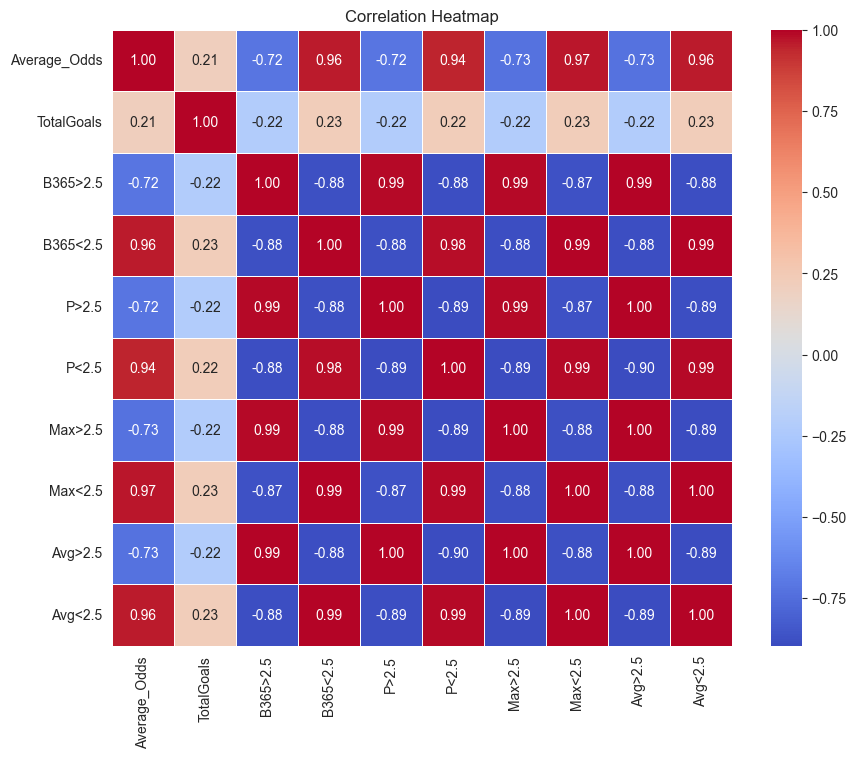

belgium


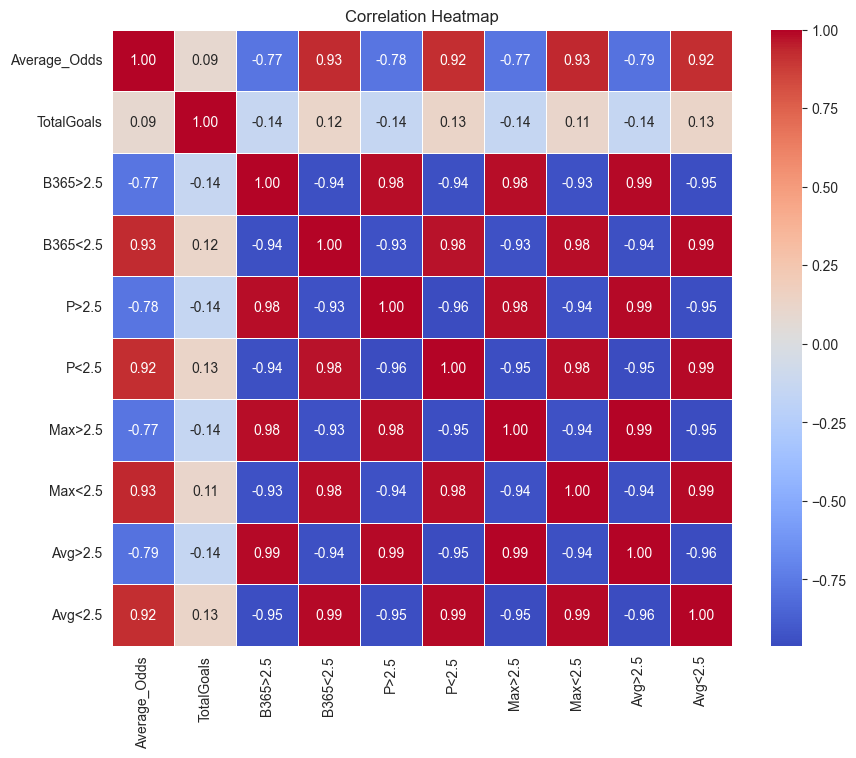

england


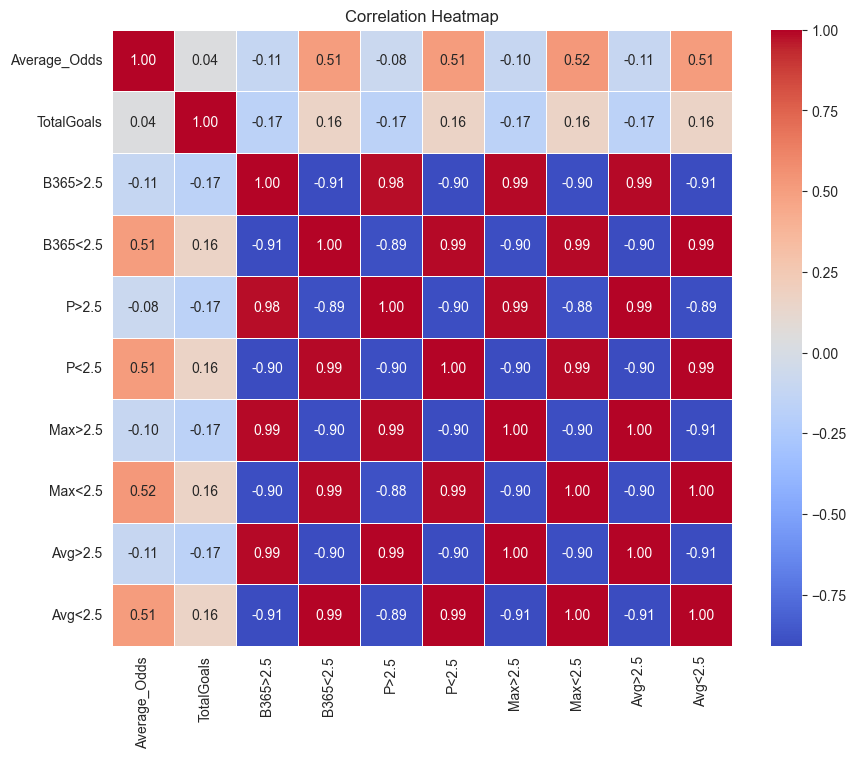

france


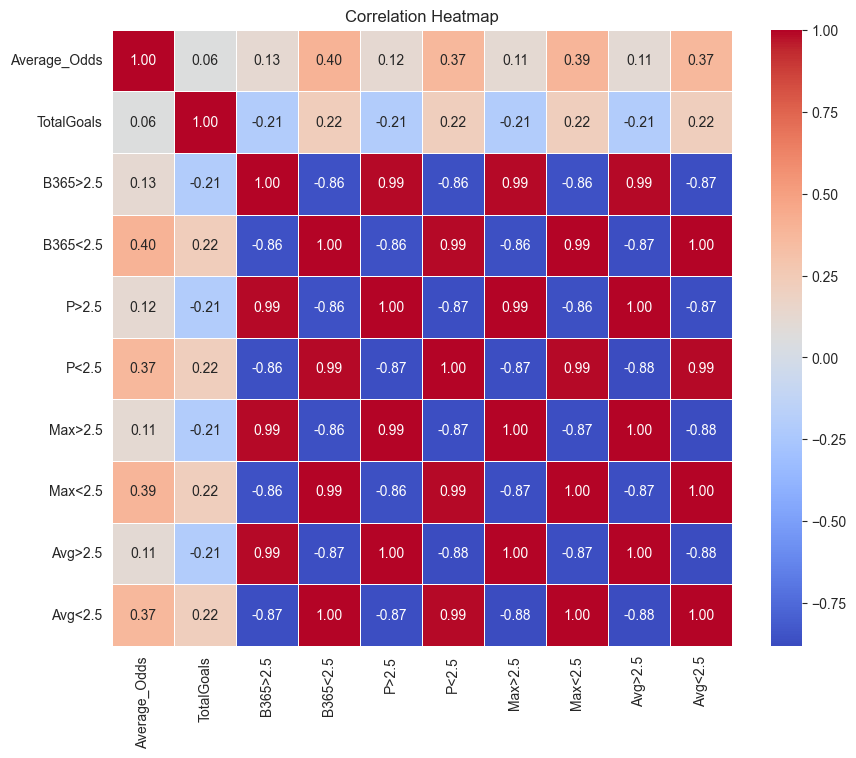

greece


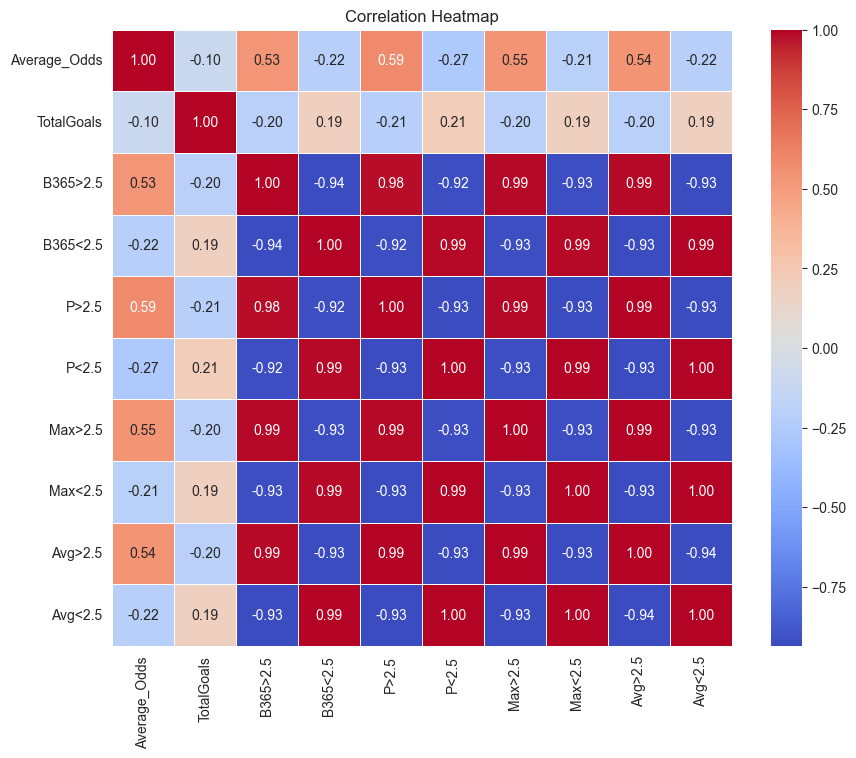

italy


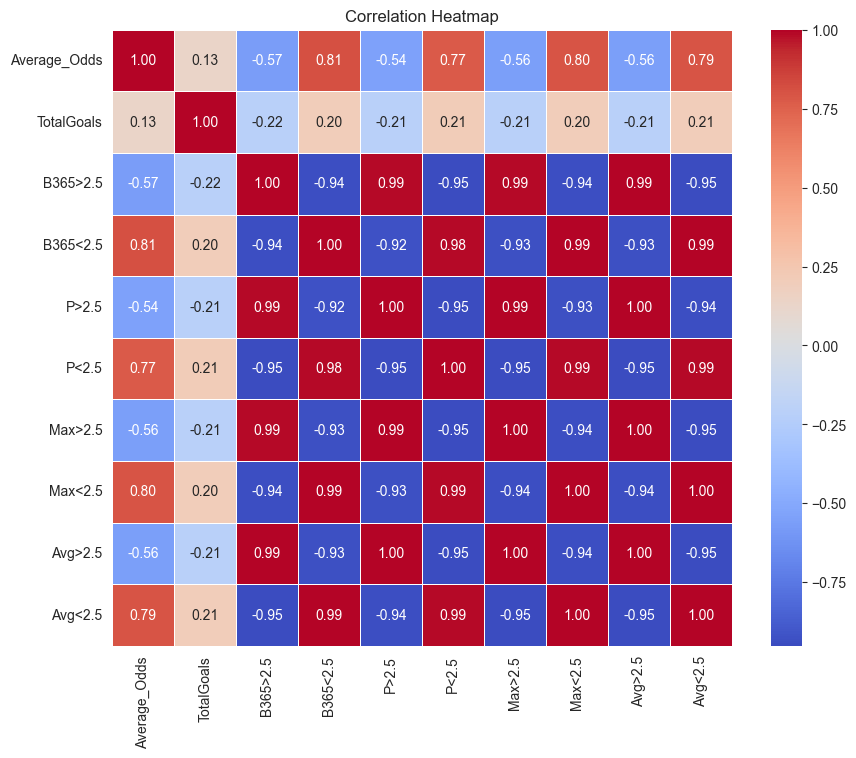

netherlands


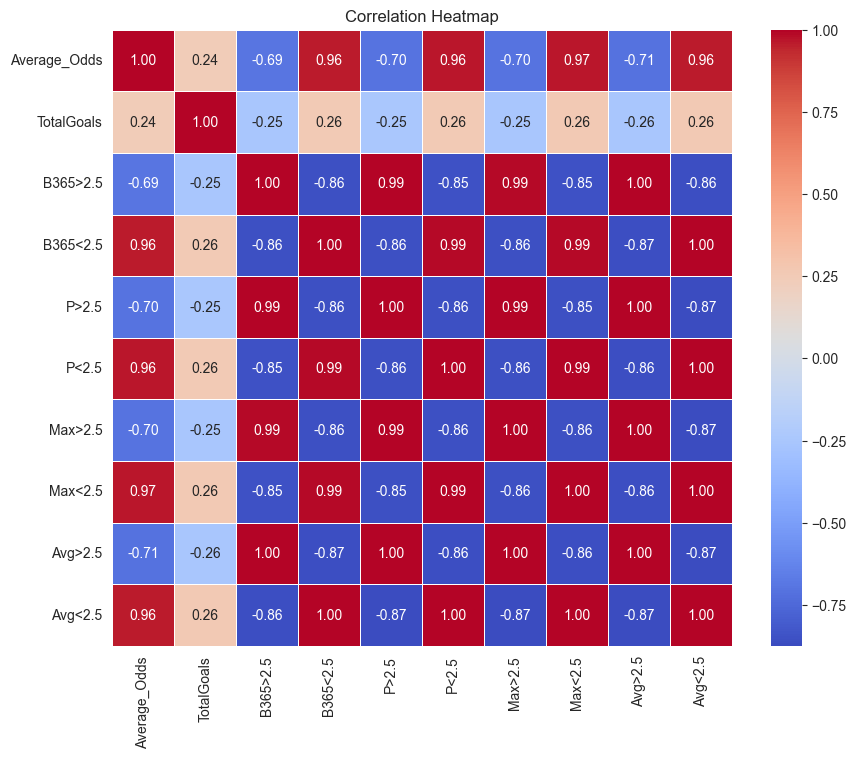

portugal


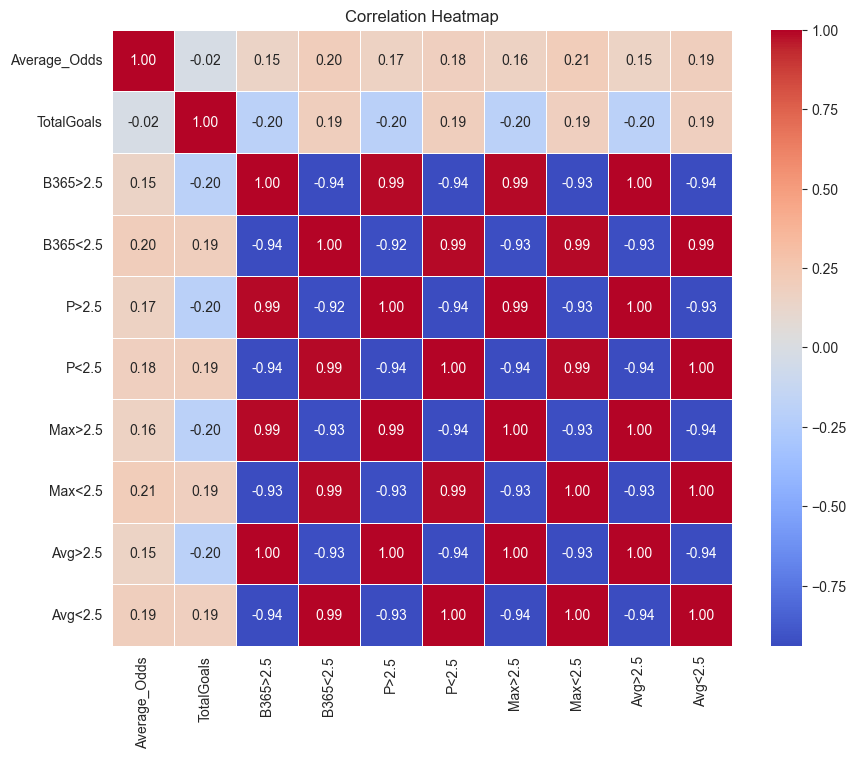

scotland


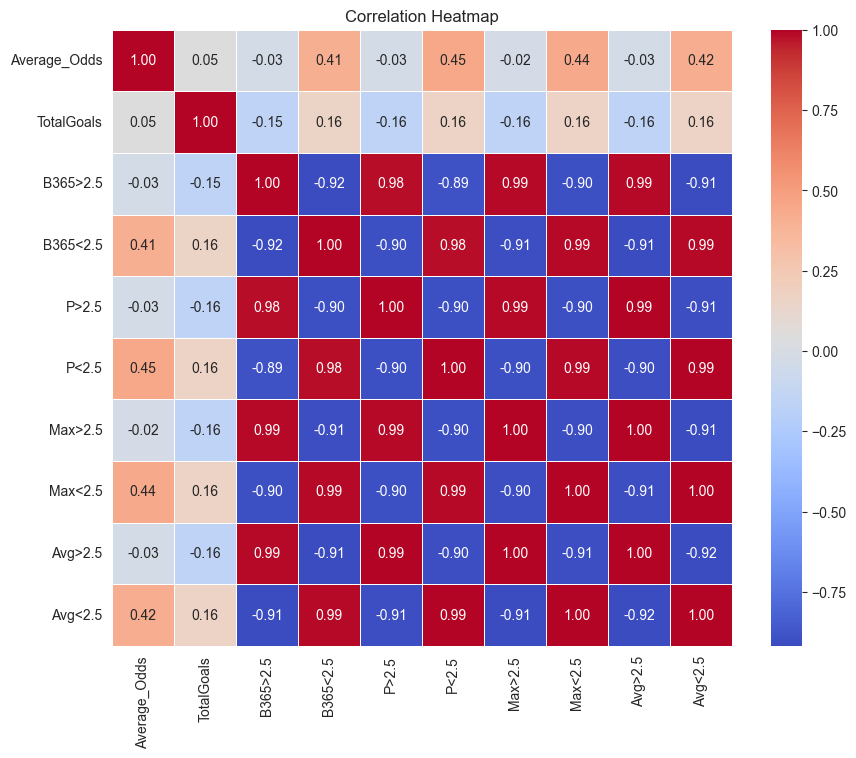

spain


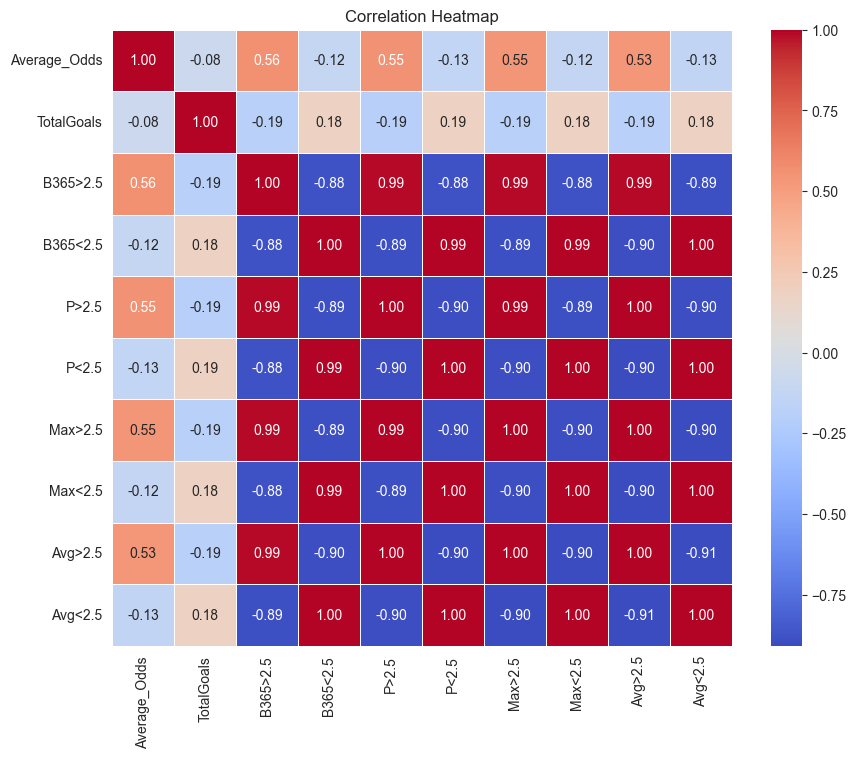

turkey


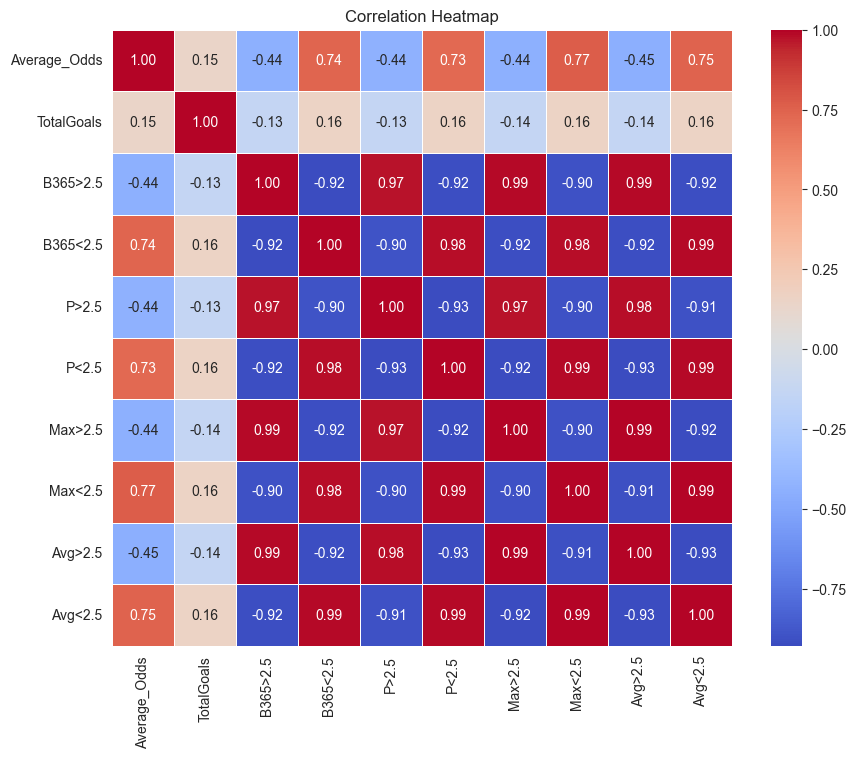

In [440]:
for country_name, country_train_data in [
    ('germany', germany_all_train_data),
    ('belgium', belgium_all_train_data),
    ('england', england_all_train_data),
    ('france', france_all_train_data),
    ('greece', greece_all_train_data),
    ('italy', italy_all_train_data),
    ('netherlands', netherlands_all_train_data),
    ('portugal', portugal_all_train_data),
    ('scotland', scotland_all_train_data),
    ('spain', spain_all_train_data),
    ('turkey', turkey_all_train_data)
]:
    country_train_data['TotalGoals'] = country_train_data['FTHG'] + country_train_data['FTAG']
    
    print(country_name)

    examine_correlation(country_train_data, goal_statistics_columns, 'TotalGoals')

In [441]:
desired_columns = ['Date', 'HomeTeam', 'AwayTeam', 'FTR', 'FTHG', 'FTAG', 'GRatioHome', 'GRatioAway',
                  'StreakHome', 'StreakAway', 'Over2GoalsHome', 'Over2GoalsAway', 'AvgHomeGoals', 'AvgAwayGoals', 
                   'LaggedH2HResult', 'PSCA', 'PSA', 'PSCH', 'AvgA', 'B365>2.5', 'B365<2.5']

filtered_german_train_data = germany_all_train_data[desired_columns]
filtered_belgium_train_data = belgium_all_train_data[desired_columns]
filtered_england_train_data = england_all_train_data[desired_columns]
filtered_france_train_data = france_all_train_data[desired_columns]
filtered_italy_train_data = italy_all_train_data[desired_columns]
filtered_netherlands_train_data = netherlands_all_train_data[desired_columns]
filtered_portugal_train_data = portugal_all_train_data[desired_columns]
filtered_scotland_train_data = scotland_all_train_data[desired_columns]
filtered_spain_train_data = spain_all_train_data[desired_columns]
filtered_turkey_train_data = turkey_all_train_data[desired_columns]

In [442]:
filtered_german_train_data

,Date,HomeTeam,AwayTeam,FTR,FTHG,FTAG,GRatioHome,GRatioAway,StreakHome,StreakAway,...,Over2GoalsAway,AvgHomeGoals,AvgAwayGoals,LaggedH2HResult,PSCA,PSA,PSCH,AvgA,B365>2.5,B365<2.5
5101,2018-12-05,Leverkusen,Hannover,H,3.0,2.0,0.000000,0.000000,0,0,...,0.000000,3.000000,2.000000,2,12.40,11.40,1.22,NaN,NaN,NaN
5106,2018-03-31,Hertha,Wolfsburg,D,0.0,0.0,0.000000,0.000000,0,0,...,0.000000,0.000000,0.000000,2,3.45,3.95,2.37,NaN,NaN,NaN
5108,2018-03-02,Freiburg,Leverkusen,D,0.0,0.0,0.000000,1.500000,0,1,...,1.000000,0.000000,3.000000,2,1.93,1.88,4.27,NaN,NaN,NaN
5111,2018-03-17,Ein Frankfurt,Mainz,H,3.0,0.0,0.000000,0.000000,0,0,...,0.000000,3.000000,0.000000,2,5.38,6.07,1.75,NaN,NaN,NaN
5114,2018-10-02,Hannover,Freiburg,H,2.0,1.0,0.666667,0.000000,-1,0,...,0.000000,2.000000,0.000000,2,3.89,3.81,2.08,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13196,2021-07-23,Schalke 04,Hamburg,A,1.0,3.0,0.771654,1.322917,-3,-1,...,0.253333,1.298013,1.693333,2,2.70,2.64,2.61,2.57,1.61,2.25
13197,2021-08-14,Sandhausen,Karlsruhe,D,0.0,0.0,0.791111,1.000000,1,4,...,0.197917,1.202703,1.500000,1,2.13,2.21,3.54,2.17,1.85,2.00
13198,2021-05-11,Holstein Kiel,Dresden,H,2.0,1.0,1.160377,0.695906,1,-4,...,0.130435,1.651007,1.034783,2,4.15,4.11,1.94,3.92,1.85,1.95
13199,2021-10-17,Dresden,Nurnberg,A,0.0,1.0,0.693642,0.755187,-5,2,...,0.093960,1.034483,1.221477,2,2.63,2.64,2.93,2.53,2.00,1.80


## test

In [443]:
# function to call all test datasets for feature addition

def call_countries_all_test(function):

    warnings.filterwarnings('ignore')
    
    # List of dataset names
    dataset_names = [
    'germany_all_test_data',
    'belgium_all_test_data',
    'england_all_test_data',
    'france_all_test_data',
    'greece_all_test_data',
    'italy_all_test_data',
    'netherlands_all_test_data',
    'portugal_all_test_data',
    'scotland_all_test_data',
    'spain_all_test_data',
    'turkey_all_test_data' 
    ]
    # Process each dataset and store the result in a dictionary
    for name in dataset_names:
            # globals() to access these datasets by name
        dataset = globals().get(name)
        if dataset is not None:
            function(dataset)
            print(f"Dataset {name} OK")
        else:
            print(f"Dataset {name} not found.")

    return print("Done :)")

In [444]:
# function to call all test datasets for feature addition
def call_countries_all_all(function):

    warnings.filterwarnings('ignore')
    
    # List of dataset names
    dataset_names = [
    'germany_all_train_data',
    'belgium_all_train_data',
    'england_all_train_data',
    'france_all_train_data',
    'greece_all_train_data',
    'italy_all_train_data',
    'netherlands_all_train_data',
    'portugal_all_train_data',
    'scotland_all_train_data',
    'spain_all_train_data',
    'turkey_all_train_data'
    'germany_all_test_data',
    'belgium_all_test_data',
    'england_all_test_data',
    'france_all_test_data',
    'greece_all_test_data',
    'italy_all_test_data',
    'netherlands_all_test_data',
    'portugal_all_test_data',
    'scotland_all_test_data',
    'spain_all_test_data',
    'turkey_all_test_data' 
    ]
    # Process each dataset and store the result in a dictionary
    for name in dataset_names:
            # globals() to access these datasets by name
        dataset = globals().get(name)
        if dataset is not None:
            function(dataset)
            print(f"Dataset {name} OK")
        else:
            print(f"Dataset {name} not found.")

    return print("Done :)")

#### % > 2.5

In [445]:
# Calculate the total number of matches and the number of matches scoring over 2 goals for each team.
def calculate_over_2_goals_stats(df):

    total_matches = {}
    matches_scoring_over_2 = {}

    # Iterate over the rows in the DataFrame
    for _, row in df.iterrows():
        home_team = row['HomeTeam']
        away_team = row['AwayTeam']
        home_goals = row['FTHG']
        away_goals = row['FTAG']

        # Update counters for each team
        total_matches[home_team] = total_matches.get(home_team, 0) + 1
        total_matches[away_team] = total_matches.get(away_team, 0) + 1
        if home_goals > 2:
            matches_scoring_over_2[home_team] = matches_scoring_over_2.get(home_team, 0) + 1
        if away_goals > 2:
            matches_scoring_over_2[away_team] = matches_scoring_over_2.get(away_team, 0) + 1

    return total_matches, matches_scoring_over_2


In [446]:
# Apply the fractions of games scoring over 2 goals calculated from the train data to the test data.
def apply_fraction_over_2_goals_to_test_data(test_df, total_matches, matches_scoring_over_2):

    test_df['Over2GoalsHome'] = 0.0
    test_df['Over2GoalsAway'] = 0.0

    # Iterate over the rows in the test DataFrame
    for index, row in test_df.iterrows():
        home_team = row['HomeTeam']
        away_team = row['AwayTeam']

        # Calculate and assign the fractions for the home team
        if home_team in total_matches and total_matches[home_team] > 0:
            test_df.at[index, 'Over2GoalsHome'] = matches_scoring_over_2.get(home_team, 0) / total_matches[home_team]

        # Calculate and assign the fractions for the away team
        if away_team in total_matches and total_matches[away_team] > 0:
            test_df.at[index, 'Over2GoalsAway'] = matches_scoring_over_2.get(away_team, 0) / total_matches[away_team]

    return test_df


In [447]:
for country_name, country_train_data, country_test_data in [
    ('germany', germany_all_train_data, germany_all_test_data),
    ('belgium', belgium_all_train_data, belgium_all_test_data),
    ('england', england_all_train_data, england_all_test_data),
    ('france', france_all_train_data, france_all_test_data),
    ('greece', greece_all_train_data, greece_all_test_data),
    ('italy', italy_all_train_data, italy_all_test_data),
    ('netherlands', netherlands_all_train_data, netherlands_all_test_data),
    ('portugal', portugal_all_train_data, portugal_all_test_data),
    ('scotland', scotland_all_train_data, scotland_all_test_data),
    ('spain', spain_all_train_data, spain_all_test_data),
    ('turkey', turkey_all_train_data, turkey_all_test_data)
]:

    total_matches, matches_scoring_over_2 = calculate_over_2_goals_stats(country_train_data)
    apply_fraction_over_2_goals_to_test_data(country_test_data, total_matches, matches_scoring_over_2)


#### h2h

In [448]:
# Calculate the last head-to-head result for each pair of teams in the dataset.
def calculate_last_h2h_results(df):

    # Create a unique key for each match (sorted pair of HomeTeam and AwayTeam)
    df['MatchKey'] = df.apply(lambda row: tuple(sorted([row['HomeTeam'], row['AwayTeam']])), axis=1)

    # Dictionary to store the last result of each match pair
    last_match_results = {}

    # Iterate over the rows in the DataFrame
    for index, row in df.iterrows():
        match_key = row['MatchKey']
        result = row['FTR']

        # Convert the result to -1/0/1 format
        result_num = -1 if result == "H" else 0 if result == "A" else 1

        # Update the last result for this match pair
        last_match_results[match_key] = result_num

    # Remove the temporary 'MatchKey' column
    df.drop('MatchKey', axis=1, inplace=True)

    return last_match_results


In [449]:
# Apply the last head-to-head results calculated from the train data to the test data.
def apply_lagged_h2h_result_to_test_data(test_df, last_h2h_results):

    test_df['LaggedH2HResult'] = 2  # Default to 'D' (Draw) if no previous match found

    # Create a unique key for each match in the test data
    test_df['MatchKey'] = test_df.apply(lambda row: tuple(sorted([row['HomeTeam'], row['AwayTeam']])), axis=1)

    # Iterate over the rows in the test DataFrame
    for index, row in test_df.iterrows():
        match_key = row['MatchKey']

        # Apply the last H2H result if available
        if match_key in last_h2h_results:
            test_df.at[index, 'LaggedH2HResult'] = last_h2h_results[match_key]

    # Remove the temporary 'MatchKey' column
    test_df.drop('MatchKey', axis=1, inplace=True)

    return test_df


In [450]:
for country_name, country_train_data, country_test_data in [
    ('germany', germany_all_train_data, germany_all_test_data),
    ('belgium', belgium_all_train_data, belgium_all_test_data),
    ('england', england_all_train_data, england_all_test_data),
    ('france', france_all_train_data, france_all_test_data),
    ('greece', greece_all_train_data, greece_all_test_data),
    ('italy', italy_all_train_data, italy_all_test_data),
    ('netherlands', netherlands_all_train_data, netherlands_all_test_data),
    ('portugal', portugal_all_train_data, portugal_all_test_data),
    ('scotland', scotland_all_train_data, scotland_all_test_data),
    ('spain', spain_all_train_data, spain_all_test_data),
    ('turkey', turkey_all_train_data, turkey_all_test_data)
]:

    last_match_results = calculate_last_h2h_results(country_train_data)
    apply_lagged_h2h_result_to_test_data(country_test_data, last_match_results)


In [451]:
# check on one example if the logic is sound
bayern_hertha_matches = germany_all_test_data[(germany_all_test_data['HomeTeam'] == 'Bayern Munich') |
                                               (germany_all_test_data['AwayTeam'] == 'Bayern Munich')]

bayern_hertha_matches[['Date', 'HomeTeam', 'AwayTeam', 'LaggedH2HResult']].head()

,Date,HomeTeam,AwayTeam,LaggedH2HResult
0,2022-05-08,Ein Frankfurt,Bayern Munich,0
17,2022-08-14,Bayern Munich,Wolfsburg,1
26,2022-08-21,Bochum,Bayern Munich,-1
33,2022-08-27,Bayern Munich,M'gladbach,1
40,2022-03-09,Union Berlin,Bayern Munich,-1


#### gratio

In [452]:
# Calculate cumulative goals scored and conceded for each team in the dataset.
def calculate_cumulative_goals_ratios(df):

    goals_scored = {}
    goals_conceded = {}

    # Iterate over the rows in the DataFrame
    for index, row in df.iterrows():
        home_team = row['HomeTeam']
        away_team = row['AwayTeam']
        home_goals = row['FTHG']
        away_goals = row['FTAG']

        # Update goals scored and conceded for each team
        goals_scored[home_team] = goals_scored.get(home_team, 0) + home_goals
        goals_conceded[home_team] = goals_conceded.get(home_team, 0) + away_goals
        goals_scored[away_team] = goals_scored.get(away_team, 0) + away_goals
        goals_conceded[away_team] = goals_conceded.get(away_team, 0) + home_goals

    return goals_scored, goals_conceded

In [453]:
# Apply the goals ratios calculated from the train data to the test data.
def apply_goals_ratios_to_test_data(test_df, goals_scored, goals_conceded):

    test_df['GRatioHome'] = 0.0
    test_df['GRatioAway'] = 0.0

    # Iterate over the rows in the test DataFrame
    for index, row in test_df.iterrows():
        home_team = row['HomeTeam']
        away_team = row['AwayTeam']

        # Calculate and assign the goals ratio for the home team
        if home_team in goals_scored and goals_conceded.get(home_team, 1) > 0:
            test_df.at[index, 'GRatioHome'] = goals_scored[home_team] / goals_conceded[home_team]
        
        # Calculate and assign the goals ratio for the away team
        if away_team in goals_scored and goals_conceded.get(away_team, 1) > 0:
            test_df.at[index, 'GRatioAway'] = goals_scored[away_team] / goals_conceded[away_team]

    return test_df

In [454]:
for country_name, country_train_data, country_test_data in [
    ('germany', germany_all_train_data, germany_all_test_data),
    ('belgium', belgium_all_train_data, belgium_all_test_data),
    ('england', england_all_train_data, england_all_test_data),
    ('france', france_all_train_data, france_all_test_data),
    ('greece', greece_all_train_data, greece_all_test_data),
    ('italy', italy_all_train_data, italy_all_test_data),
    ('netherlands', netherlands_all_train_data, netherlands_all_test_data),
    ('portugal', portugal_all_train_data, portugal_all_test_data),
    ('scotland', scotland_all_train_data, scotland_all_test_data),
    ('spain', spain_all_train_data, spain_all_test_data),
    ('turkey', turkey_all_train_data, turkey_all_test_data)
]:

    cumulative_goals_scored, cumulative_goals_conceded = calculate_cumulative_goals_ratios(country_train_data)
    apply_goals_ratios_to_test_data(country_test_data, cumulative_goals_scored, cumulative_goals_conceded)

In [455]:
# check on one example if the logic is sound
bayern_hertha_matches = germany_all_test_data[(germany_all_test_data['HomeTeam'] == 'Bayern Munich') |
                                               (germany_all_test_data['AwayTeam'] == 'Bayern Munich')]

bayern_hertha_matches[['Date', 'HomeTeam', 'AwayTeam', 'GRatioHome', 'GRatioAway']].head()

,Date,HomeTeam,AwayTeam,GRatioHome,GRatioAway
0,2022-05-08,Ein Frankfurt,Bayern Munich,1.090909,2.737500
17,2022-08-14,Bayern Munich,Wolfsburg,2.737500,1.028708
26,2022-08-21,Bochum,Bayern Munich,1.061905,2.737500
33,2022-08-27,Bayern Munich,M'gladbach,2.737500,1.150685
40,2022-03-09,Union Berlin,Bayern Munich,1.082051,2.737500


#### avg goals per team + reg feature of avg goals per match

In [456]:
# Calculate cumulative sum of goals and match count for each team in the dataset.
def calculate_cumulative_goals_average(df):
    
    sum_goals = {}
    match_count = {}

    # Iterate over the rows in the DataFrame
    for index, row in df.iterrows():
        home_team = row['HomeTeam']
        away_team = row['AwayTeam']
        home_goals = row['FTHG']
        away_goals = row['FTAG']

        # Update sum_goals and match_count for each team
        sum_goals[home_team] = sum_goals.get(home_team, 0) + home_goals
        match_count[home_team] = match_count.get(home_team, 0) + 1
        sum_goals[away_team] = sum_goals.get(away_team, 0) + away_goals
        match_count[away_team] = match_count.get(away_team, 0) + 1

    return sum_goals, match_count


In [457]:
# Apply the lagged goals averages calculated from the train data to the test data.
def apply_lagged_goals_average_to_test_data(test_df, sum_goals, match_count):

    test_df['AvgHomeGoals'] = 0.0
    test_df['AvgAwayGoals'] = 0.0

    # Iterate over the rows in the test DataFrame
    for index, row in test_df.iterrows():
        home_team = row['HomeTeam']
        away_team = row['AwayTeam']

        # Calculate and assign the average goals for the home team
        if home_team in sum_goals and match_count[home_team] > 0:
            test_df.at[index, 'AvgHomeGoals'] = sum_goals[home_team] / match_count[home_team]

        # Calculate and assign the average goals for the away team
        if away_team in sum_goals and match_count[away_team] > 0:
            test_df.at[index, 'AvgAwayGoals'] = sum_goals[away_team] / match_count[away_team]

    return test_df


In [458]:
for country_name, country_train_data, country_test_data in [
    ('germany', germany_all_train_data, germany_all_test_data),
    ('belgium', belgium_all_train_data, belgium_all_test_data),
    ('england', england_all_train_data, england_all_test_data),
    ('france', france_all_train_data, france_all_test_data),
    ('greece', greece_all_train_data, greece_all_test_data),
    ('italy', italy_all_train_data, italy_all_test_data),
    ('netherlands', netherlands_all_train_data, netherlands_all_test_data),
    ('portugal', portugal_all_train_data, portugal_all_test_data),
    ('scotland', scotland_all_train_data, scotland_all_test_data),
    ('spain', spain_all_train_data, spain_all_test_data),
    ('turkey', turkey_all_train_data, turkey_all_test_data)
]:

    cumulative_sum_goals, cumulative_match_count = calculate_cumulative_goals_average(country_train_data)
    apply_lagged_goals_average_to_test_data(country_test_data, cumulative_sum_goals, cumulative_match_count)


In [459]:
# check on one example if the logic is sound
bayern_hertha_matches = germany_all_test_data[(germany_all_test_data['HomeTeam'] == 'Bayern Munich') |
                                               (germany_all_test_data['AwayTeam'] == 'Bayern Munich')]

bayern_hertha_matches[['Date', 'HomeTeam', 'AwayTeam', 'AvgHomeGoals', 'AvgAwayGoals']].head()

,Date,HomeTeam,AwayTeam,AvgHomeGoals,AvgAwayGoals
0,2022-05-08,Ein Frankfurt,Bayern Munich,1.691275,2.881579
17,2022-08-14,Bayern Munich,Wolfsburg,2.881579,1.452703
26,2022-08-21,Bochum,Bayern Munich,1.476821,2.881579
33,2022-08-27,Bayern Munich,M'gladbach,2.881579,1.680000
40,2022-03-09,Union Berlin,Bayern Munich,1.416107,2.881579


#### avg odds

In [460]:
call_countries_all_test(avg_win_odd_calc)

Dataset germany_all_test_data OK
Dataset belgium_all_test_data OK
Dataset england_all_test_data OK
Dataset france_all_test_data OK
Dataset greece_all_test_data OK
Dataset italy_all_test_data OK
Dataset netherlands_all_test_data OK
Dataset portugal_all_test_data OK
Dataset scotland_all_test_data OK
Dataset spain_all_test_data OK
Dataset turkey_all_test_data OK
Done :)


In [461]:
# check on corr matrix to review logic
dt = germany_all_test_data[['AvgH','AvgHomeWinOdds', 'AvgDrawOdds', 'AvgAwayWinOdds']]
dt.corr()

,AvgH,AvgHomeWinOdds,AvgDrawOdds,AvgAwayWinOdds
AvgH,1.000000,0.994141,0.111502,-0.492691
AvgHomeWinOdds,0.994141,1.000000,0.092883,-0.511889
AvgDrawOdds,0.111502,0.092883,1.000000,0.774716
AvgAwayWinOdds,-0.492691,-0.511889,0.774716,1.000000


In [462]:
germany_all_test_data[['Date', 'HomeTeam', 'AwayTeam', 'AvgHomeWinOdds', 'AvgDrawOdds', 'AvgAwayWinOdds']]

,Date,HomeTeam,AwayTeam,AvgHomeWinOdds,AvgDrawOdds,AvgAwayWinOdds
0,2022-05-08,Ein Frankfurt,Bayern Munich,4.863750,4.898333,1.608125
1,2022-06-08,Augsburg,Freiburg,3.045625,3.477500,2.083750
2,2022-06-08,Bochum,Mainz,2.929375,3.396667,2.165000
3,2022-06-08,M'gladbach,Hoffenheim,2.064375,3.945833,2.848125
4,2022-06-08,Union Berlin,Hertha,1.856250,3.646667,3.809375
...,...,...,...,...,...,...
607,2023-05-28,Magdeburg,Bielefeld,2.853125,4.126667,1.965625
608,2023-05-28,Paderborn,Nurnberg,1.920625,4.025833,3.050000
609,2023-05-28,Regensburg,Heidenheim,4.838750,4.274167,1.626875
610,2023-05-28,Sandhausen,Hamburg,6.259375,5.565000,1.469375


In [463]:
pd.isna(germany_all_test_data).sum()

Div               0
Date              0
Time              0
HomeTeam          0
AwayTeam          0
                 ..
AvgHomeGoals      0
AvgAwayGoals      0
AvgHomeWinOdds    0
AvgDrawOdds       0
AvgAwayWinOdds    0
Length: 97, dtype: int64

#### avg win rate

In [464]:
# Calculate the overall win rates for each team in the dataset.
def calculate_team_win_rates(df):

    home_win_count = {}
    away_win_count = {}
    home_game_count = {}
    away_game_count = {}

    # Iterate over the rows in the DataFrame to count wins and games
    for _, row in df.iterrows():
        home_team = row['HomeTeam']
        away_team = row['AwayTeam']
        result = row['FTR']

        # Update game counts
        home_game_count[home_team] = home_game_count.get(home_team, 0) + 1
        away_game_count[away_team] = away_game_count.get(away_team, 0) + 1

        # Update win counts based on the match result
        if result == 'H':  # Home win
            home_win_count[home_team] = home_win_count.get(home_team, 0) + 1
        elif result == 'A':  # Away win
            away_win_count[away_team] = away_win_count.get(away_team, 0) + 1

    # Calculate win rates
    home_win_rate = {team: wins / home_game_count[team] for team, wins in home_win_count.items()}
    away_win_rate = {team: wins / away_game_count[team] for team, wins in away_win_count.items()}

    return home_win_rate, away_win_rate


In [465]:
# Apply the overall home and away win rates to the test dataset.
def apply_win_rates_to_test_data(test_df, home_win_rate, away_win_rate):

    # Initialize new columns for win rates
    test_df['HomeTeamWinRate'] = 0.5
    test_df['AwayTeamWinRate'] = 0.5

    # Iterate over the rows in the test DataFrame and apply win rates
    for index, row in test_df.iterrows():
        home_team = row['HomeTeam']
        away_team = row['AwayTeam']

        # Apply the home win rate for the home team
        test_df.at[index, 'HomeWinRate'] = home_win_rate.get(home_team, 0)

        # Apply the away win rate for the away team
        test_df.at[index, 'AwayWinRate'] = away_win_rate.get(away_team, 0)

    return test_df


In [466]:
for country_name, country_train_data, country_test_data in [
    ('germany', germany_all_train_data, germany_all_test_data),
    ('belgium', belgium_all_train_data, belgium_all_test_data),
    ('england', england_all_train_data, england_all_test_data),
    ('france', france_all_train_data, france_all_test_data),
    ('greece', greece_all_train_data, greece_all_test_data),
    ('italy', italy_all_train_data, italy_all_test_data),
    ('netherlands', netherlands_all_train_data, netherlands_all_test_data),
    ('portugal', portugal_all_train_data, portugal_all_test_data),
    ('scotland', scotland_all_train_data, scotland_all_test_data),
    ('spain', spain_all_train_data, spain_all_test_data),
    ('turkey', turkey_all_train_data, turkey_all_test_data)
]:

    home_win_rate, away_win_rate = calculate_team_win_rates(country_train_data)
    apply_win_rates_to_test_data(country_test_data, home_win_rate, away_win_rate)

In [467]:
# check on one example if the logic is sound
bayern_matches = germany_all_test_data[(germany_all_test_data['HomeTeam'] == 'Bayern Munich') |
                                               (germany_all_test_data['AwayTeam'] == 'Bayern Munich')]

bayern_matches[['Date', 'HomeTeam', 'AwayTeam', 'HomeWinRate', 'AwayWinRate']].head()

,Date,HomeTeam,AwayTeam,HomeWinRate,AwayWinRate
0,2022-05-08,Ein Frankfurt,Bayern Munich,0.460526,0.706667
17,2022-08-14,Bayern Munich,Wolfsburg,0.766234,0.405405
26,2022-08-21,Bochum,Bayern Munich,0.500000,0.706667
33,2022-08-27,Bayern Munich,M'gladbach,0.766234,0.328947
40,2022-03-09,Union Berlin,Bayern Munich,0.526316,0.706667


# Final datasets used for modeling

In [468]:
subset_columns = ['Div', 'Date', 'HomeTeam', 'AwayTeam', 'LaggedH2HResult', 'AvgHomeGoals', 'AvgAwayGoals', 
                  'GRatioHome', 'GRatioAway', 'AvgHomeWinOdds', 'Over2GoalsHome', 'Over2GoalsAway',
                  'AvgDrawOdds', 'AvgAwayWinOdds', 'TotalGoals', 'FTR', 'HomeWinRate', 'AwayWinRate']

subset_test_columns = ['Div', 'Date', 'HomeTeam', 'AwayTeam', 'LaggedH2HResult', 'AvgHomeGoals', 'AvgAwayGoals', 
                  'GRatioHome', 'GRatioAway', 'AvgHomeWinOdds',  'Over2GoalsHome', 'Over2GoalsAway',
                  'AvgDrawOdds', 'AvgAwayWinOdds', 'HomeWinRate', 'AwayWinRate']

for dataset in ['germany_all_train_data', 'belgium_all_train_data', 'england_all_train_data', 
                'france_all_train_data', 'greece_all_train_data', 'italy_all_train_data', 
                'netherlands_all_train_data', 'portugal_all_train_data', 'scotland_all_train_data', 
                'spain_all_train_data', 'turkey_all_train_data']:
    globals()[dataset] = globals()[dataset][subset_columns]

for dataset in ['germany_all_test_data', 'belgium_all_test_data', 'england_all_test_data', 
                'france_all_test_data', 'greece_all_test_data', 'italy_all_test_data', 
                'netherlands_all_test_data', 'portugal_all_test_data', 'scotland_all_test_data', 
                'spain_all_test_data', 'turkey_all_test_data']:
    globals()[dataset] = globals()[dataset][subset_test_columns]


In [469]:
germany_all_train_data = germany_all_train_data.dropna()
belgium_all_train_data = belgium_all_train_data.dropna()
england_all_train_data = england_all_train_data.dropna()
france_all_train_data = france_all_train_data.dropna()
greece_all_train_data = greece_all_train_data.dropna()
italy_all_train_data = italy_all_train_data.dropna()
netherlands_all_train_data = netherlands_all_train_data.dropna()
portugal_all_train_data = portugal_all_train_data.dropna()
scotland_all_train_data = scotland_all_train_data.dropna()
spain_all_train_data = spain_all_train_data.dropna()
turkey_all_train_data = turkey_all_train_data.dropna()

In [470]:
spain_all_train_data.head()

,Div,Date,HomeTeam,AwayTeam,LaggedH2HResult,AvgHomeGoals,AvgAwayGoals,GRatioHome,GRatioAway,AvgHomeWinOdds,Over2GoalsHome,Over2GoalsAway,AvgDrawOdds,AvgAwayWinOdds,TotalGoals,FTR,HomeWinRate,AwayWinRate
6325,SP1,2018-01-29,Celta,Betis,2,3.0,2.0,0.0,0.0,2.1,1.0,0.0,2.1,2.1,5.0,H,0.5,0.5
6326,SP1,2018-09-05,Barcelona,Villarreal,2,5.0,1.0,0.0,0.0,2.1,1.0,0.0,2.1,2.1,6.0,H,0.5,0.5
6327,SP1,2018-04-02,Girona,Ath Bilbao,2,2.0,0.0,0.0,0.0,2.1,0.0,0.0,2.1,2.1,2.0,H,0.5,0.5
6329,SP1,2018-01-14,Levante,Celta,2,0.0,3.0,0.0,1.5,2.1,0.0,1.0,2.1,2.1,1.0,A,0.5,1.0
6332,SP1,2018-04-29,La Coruna,Barcelona,2,2.0,5.0,0.0,5.0,2.1,0.0,1.0,2.1,2.1,6.0,A,0.5,1.0


In [471]:
spain_all_test_data.head()

,Div,Date,HomeTeam,AwayTeam,LaggedH2HResult,AvgHomeGoals,AvgAwayGoals,GRatioHome,GRatioAway,AvgHomeWinOdds,Over2GoalsHome,Over2GoalsAway,AvgDrawOdds,AvgAwayWinOdds,HomeWinRate,AwayWinRate
0,SP1,2022-12-08,Osasuna,Sevilla,1,1.137143,1.457831,0.975490,1.375000,2.843125,0.097143,0.156627,3.034167,2.381250,0.471910,0.392857
1,SP1,2022-08-13,Celta,Espanol,-1,1.257310,1.183908,0.884774,0.995169,1.810000,0.140351,0.091954,3.580833,4.092500,0.390805,0.229885
2,SP1,2022-08-13,Valladolid,Villarreal,-1,1.104046,1.526627,0.892523,1.234450,3.271875,0.080925,0.171598,3.476667,2.013750,0.364706,0.349398
3,SP1,2022-08-13,Barcelona,Vallecano,-1,2.213873,1.258242,2.226744,0.970339,1.403125,0.364162,0.115385,6.656667,10.484375,0.724138,0.252747
4,SP1,2022-08-14,Cadiz,Sociedad,0,1.072222,1.365269,0.974747,1.212766,3.243750,0.077778,0.167665,3.120833,2.121250,0.355556,0.341176


# Modelling with new features - Classification

## Random forest classifier

In [472]:
# Preprocesses dataframe for classification
def new_preprocess(df, unique_team_names):

    df_copy = df.copy()

    df_copy = df_copy[['Div', 'Date', 'HomeTeam', 'AwayTeam', 'LaggedH2HResult', 'AvgHomeGoals', 'AvgAwayGoals', 
                  'GRatioHome', 'GRatioAway', 'AvgHomeWinOdds', 'Over2GoalsHome', 'Over2GoalsAway',
                  'AvgDrawOdds', 'AvgAwayWinOdds', 'FTR']]

    # transform Date into epoch
    df_copy['Date'] = (pd.to_datetime(df_copy['Date']).astype('int64') / 10**11)

    # make column Div categorical
    df_copy['Div'] = df_copy['Div'].astype('category')

    # Create dummy variables for each team from unique_team_names if 'HomeTeam' column exists
    if 'HomeTeam' in df_copy.columns:
        for team in unique_team_names:
            df_copy[f'HomeTeam_{team}'] = df_copy['HomeTeam'] == team
            df_copy[f'AwayTeam_{team}'] = df_copy['AwayTeam'] == team
            
            

    return df_copy.reset_index(drop=True)


In [473]:
def new_preprocess_test(df, team_names):
    """
    Preprocesses test dataframe for classification. Fill missing values,
    filter invalid data, create dummy variables, etc.
    """
    df_copy = df.copy()

    df_copy = df_copy[['Div', 'Date', 'HomeTeam', 'AwayTeam', 'LaggedH2HResult', 'AvgHomeGoals', 'AvgAwayGoals', 
                  'GRatioHome', 'GRatioAway', 'AvgHomeWinOdds', 'Over2GoalsHome', 'Over2GoalsAway',
                  'AvgDrawOdds', 'AvgAwayWinOdds']]


    # Transform 'Date' into epoch
    df_copy['Date'] = pd.to_datetime(df_copy['Date']).astype('int64') // 10**11

    # Make column 'Div' categorical
    df_copy['Div'] = df_copy['Div'].astype('category')

    # Create dummy variables for each team from unique_team_names if 'HomeTeam' column exists
    if 'HomeTeam' in df_copy.columns:
        for team in team_names:
            df_copy[f'HomeTeam_{team}'] = df_copy['HomeTeam'] == team
            df_copy[f'AwayTeam_{team}'] = df_copy['AwayTeam'] == team


    return df_copy.reset_index(drop=True)

In [474]:
# Create a pipeline with a preprocessor and a Random Forest Classifier.
def new_create_model_pipeline(numerical_features, categorical_features, n_estimators=64, max_depth=8, random_state=42):

    # Create a preprocessor using ColumnTransformer and Pipeline
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', 'passthrough', numerical_features),
            ('cat', OneHotEncoder(), categorical_features)
        ])

    # Create a Random Forest Classifier
    rf_classifier = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=random_state)

    # Create a pipeline that combines the preprocessor and the classifier
    model = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', rf_classifier)])

    return model


In [475]:
class_all_f1_scores = []

for country_name, country_train_data, country_test_data in [
    ('germany', germany_all_train_data, germany_all_test_data),
    ('belgium', belgium_all_train_data, belgium_all_test_data),
    ('england', england_all_train_data, england_all_test_data),
    ('france', france_all_train_data, france_all_test_data),
    ('greece', greece_all_train_data, greece_all_test_data),
    ('italy', italy_all_train_data, italy_all_test_data),
    ('netherlands', netherlands_all_train_data, netherlands_all_test_data),
    ('portugal', portugal_all_train_data, portugal_all_test_data),
    ('scotland', scotland_all_train_data, scotland_all_test_data),
    ('spain', spain_all_train_data, spain_all_test_data),
    ('turkey', turkey_all_train_data, turkey_all_test_data)
]:
    print(f"\nProcessing data for country: {country_name}")
    
    # Baseline dataset
    
    unique_team_names = set()

    unique_team_names = unique_team_names.union(set(country_train_data['AwayTeam'].unique()))

    # Preprocess data for the current country
    processed_data = new_preprocess(country_train_data, unique_team_names)

    # Split data into training and validation sets
    #X_train, X_val, X_test, y_train, y_val, y_test = chronological_split(processed_data, 'FTR', 'Date', val_size=0.2, test_size=0.2)
    # X_train, X_val, X_test, y_train, y_val, y_test = split_data(processed_data, 'FTR', val_size=0.2, test_size=0.2, random_state=42)
    X_train, X_test, y_train, y_test = split_data(processed_data, 'FTR', test_size=0.2, random_state=42)

    # Classify features for the current country
    numerical_features, categorical_features = classify_features(X_train)

    # Create the model pipeline
    model = new_create_model_pipeline(numerical_features, categorical_features, 128, 64)
    # 128/64 -> .4368
    # 1024/256 -> .4226

    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Evaluate the model for the current country
    evaluate_model(model, X_test, y_test)
    class_all_f1_scores.append(F1_score_model(model, X_test, y_test))

    # Preprocess test data for the current country
    processed_data_test = new_preprocess_test(country_test_data, unique_team_names)

    # Save predictions on the test set
    save_predictions(model, processed_data_test, country_name, "predictions/class/rf")


average_f1_score = sum(class_all_f1_scores) / len(class_all_f1_scores)
print(f"\nAverage F1 Score across countries: {average_f1_score:.4f}")



Processing data for country: germany
F1 Score: 0.3992

Confusion Matrix:
[[ 69  23  59]
 [ 39  17  80]
 [ 54  32 164]]

Processing data for country: belgium
F1 Score: 0.4184

Confusion Matrix:
[[37 12 23]
 [22  4 22]
 [23  8 75]]

Processing data for country: england
F1 Score: 0.4091

Confusion Matrix:
[[224  45 243]
 [142  54 240]
 [147  71 553]]

Processing data for country: france
F1 Score: 0.4170

Confusion Matrix:
[[ 75  31  71]
 [ 59  36  80]
 [ 54  44 178]]

Processing data for country: greece
F1 Score: 0.4961

Confusion Matrix:
[[33 11 12]
 [20 11 17]
 [16 17 75]]

Processing data for country: italy
F1 Score: 0.3793

Confusion Matrix:
[[ 81  34  78]
 [ 56  27 112]
 [ 62  42 175]]

Processing data for country: netherlands
F1 Score: 0.3917

Confusion Matrix:
[[33  2 35]
 [27  4 34]
 [24  6 89]]

Processing data for country: portugal
F1 Score: 0.5210

Confusion Matrix:
[[52 17 25]
 [13 21 32]
 [20 15 78]]

Processing data for country: scotland
F1 Score: 0.4251

Confusion Matrix:


### Hyperparameter tuning

## Support Vector Machines (SVM)

In [476]:
# Create a pipeline with a preprocessor and a multiclass AdaBoost Classifier with Decision Tree weak learner.
def create_svm_pipeline(numerical_features, categorical_features):

    # Create a preprocessor using ColumnTransformer and Pipeline
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', 'passthrough', numerical_features),
            ('cat', OneHotEncoder(), categorical_features)
        ])

    svm = SVC()
    
    # Create a pipeline that combines the preprocessor and the classifier
    model = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', svm)])

    return model

In [477]:
def create_grid_search(pipeline, param_grid, n_splits=5, scoring='f1_macro', n_jobs=-1):
    # Create a TimeSeriesSplit cross-validator
    tscv = TimeSeriesSplit(n_splits=n_splits)

    grid_search = GridSearchCV(
        pipeline, 
        param_grid, 
        cv=tscv,  # Using Time Series Cross-Validation
        scoring=scoring,
        n_jobs=n_jobs  # Use all available CPU cores
    )
    return grid_search

In [478]:
class_all_f1_scores = []

for country_name, country_train_data, country_test_data in [
    ('germany', germany_all_train_data, germany_all_test_data),
    ('belgium', belgium_all_train_data, belgium_all_test_data),
    ('england', england_all_train_data, england_all_test_data),
    ('france', france_all_train_data, france_all_test_data),
    ('greece', greece_all_train_data, greece_all_test_data),
    ('italy', italy_all_train_data, italy_all_test_data),
    ('netherlands', netherlands_all_train_data, netherlands_all_test_data),
    ('portugal', portugal_all_train_data, portugal_all_test_data),
    ('scotland', scotland_all_train_data, scotland_all_test_data),
    ('spain', spain_all_train_data, spain_all_test_data),
    ('turkey', turkey_all_train_data, turkey_all_test_data)
]:
    print(f"\nProcessing data for country: {country_name}")
    
    # Baseline dataset
    
    unique_team_names = set()

    unique_team_names = unique_team_names.union(set(country_train_data['AwayTeam'].unique()))

    # Preprocess data for the current country
    processed_data = new_preprocess(country_train_data, unique_team_names)

    # Split data into training and validation sets
    #X_train, X_val, X_test, y_train, y_val, y_test = chronological_split(processed_data, 'FTR', 'Date', val_size=0.2, test_size=0.2)
    X_train, X_test, y_train, y_test = split_data(processed_data, 'FTR', test_size=0.2, random_state=42)

    # Classify features for the current country
    numerical_features, categorical_features = classify_features(X_train)

    # Create the model pipeline    
    model_svm = create_svm_pipeline(numerical_features, categorical_features)
    param_grid_svm = {
        'classifier__C': [0.1, 1, 10],
        'classifier__kernel': ['rbf'],
        'classifier__gamma': ['scale', 'auto', 0.1, 1],
    }
    
    svm_search = create_grid_search(model_svm, param_grid_svm)
    
    svm_search.fit(X_train, y_train)
    
    best_params_svm = svm_search.best_params_
    print(f"Best parameters for {country_name} (GB): {best_params_svm}")

    # Evaluate the model for the current country
    evaluate_model(svm_search, X_test, y_test)

    # Preprocess test data for the current country
    #processed_data_test = new_preprocess_test(country_test_data, unique_team_names)

    # Save predictions on the test set
    #save_predictions(model, processed_data_test, country_name, "predictions/class/rf")


Processing data for country: germany
Best parameters for germany (GB): {'classifier__C': 10, 'classifier__gamma': 'auto', 'classifier__kernel': 'rbf'}
F1 Score: 0.3763

Confusion Matrix:
[[ 57  34  60]
 [ 34  29  73]
 [ 67  47 136]]

Processing data for country: belgium
Best parameters for belgium (GB): {'classifier__C': 1, 'classifier__gamma': 'auto', 'classifier__kernel': 'rbf'}
F1 Score: 0.3323

Confusion Matrix:
[[18 10 44]
 [17  6 25]
 [21 16 69]]

Processing data for country: england
Best parameters for england (GB): {'classifier__C': 10, 'classifier__gamma': 0.1, 'classifier__kernel': 'rbf'}
F1 Score: 0.3607

Confusion Matrix:
[[167 105 240]
 [130  88 218]
 [185 153 433]]

Processing data for country: france
Best parameters for france (GB): {'classifier__C': 10, 'classifier__gamma': 0.1, 'classifier__kernel': 'rbf'}
F1 Score: 0.3517

Confusion Matrix:
[[ 52  34  91]
 [ 54  40  81]
 [ 68  59 149]]

Processing data for country: greece
Best parameters for greece (GB): {'classifier

### Hyperparameter tuning

## Multiclass AdaBoost

In [479]:
# Create a pipeline with a preprocessor and a multiclass AdaBoost Classifier with Decision Tree weak learner.
def create_adaboost_pipeline(numerical_features, categorical_features, n_estimators=400, max_leaf_nodes=12, random_state=42):

    # Create a preprocessor using ColumnTransformer and Pipeline
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', 'passthrough', numerical_features),
            ('cat', OneHotEncoder(), categorical_features)
        ])

    # Create a Decision Tree Classifier as the weak learner
    weak_learner = DecisionTreeClassifier(max_leaf_nodes=max_leaf_nodes)

    # Create a multiclass AdaBoost Classifier
    adaboost_clf = AdaBoostClassifier(
        base_estimator=weak_learner,
        n_estimators=n_estimators,
        algorithm="SAMME",
        random_state=random_state
    )

    # Create a pipeline that combines the preprocessor and the classifier
    model = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', adaboost_clf)])

    return model


In [480]:
adaboost_val = []
#adaboost_test = []

In [481]:
for country_name, country_train_data, country_test_data in [
    ('germany', germany_all_train_data, germany_all_test_data),
    ('belgium', belgium_all_train_data, belgium_all_test_data),
    ('england', england_all_train_data, england_all_test_data),
    ('france', france_all_train_data, france_all_test_data),
    ('greece', greece_all_train_data, greece_all_test_data),
    ('italy', italy_all_train_data, italy_all_test_data),
    ('netherlands', netherlands_all_train_data, netherlands_all_test_data),
    ('portugal', portugal_all_train_data, portugal_all_test_data),
    ('scotland', scotland_all_train_data, scotland_all_test_data),
    ('spain', spain_all_train_data, spain_all_test_data),
    ('turkey', turkey_all_train_data, turkey_all_test_data)
]:
    print(f"\nProcessing data for country: {country_name}")
    
    # Baseline dataset
    
    unique_team_names = set()

    unique_team_names = unique_team_names.union(set(country_train_data['AwayTeam'].unique()))

    # Preprocess data for the current country
    processed_data = new_preprocess(country_train_data, unique_team_names)

    # Split data into training and validation sets
    #X_train, X_val, X_test, y_train, y_val, y_test = chronological_split(processed_data, 'FTR', 'Date', val_size=0.2, test_size=0.2)
    #X_train, X_val, X_test, y_train, y_val, y_test = split_data(processed_data, 'FTR', val_size=0.2, test_size=0.2, random_state=42)
    X_train, X_test, y_train, y_test = split_data(processed_data, 'FTR', test_size=0.2, random_state=42)

    # Classify features for the current country
    numerical_features, categorical_features = classify_features(X_train)

    # Create the model pipeline
    model = create_adaboost_pipeline(numerical_features, categorical_features, 400, 12, 42)

    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Evaluate the model for the current country
    evaluate_model(model, X_test, y_test)
    adaboost_val.append(F1_score_model(model, X_test, y_test))
    
    #evaluate_model(model, X_test, y_test)
    #adaboost_test.append(F1_score_model(model, X_test, y_test))

    # Preprocess test data for the current country
    processed_data_test = new_preprocess_test(country_test_data, unique_team_names)

    # Save predictions on the test set
    save_predictions(model, processed_data_test, country_name, "predictions/class/adaboost")



Processing data for country: germany
F1 Score: 0.4129

Confusion Matrix:
[[ 68  30  53]
 [ 40  28  68]
 [ 57  44 149]]

Processing data for country: belgium
F1 Score: 0.4414

Confusion Matrix:
[[38 13 21]
 [19  9 20]
 [26 14 66]]

Processing data for country: england
F1 Score: 0.3971

Confusion Matrix:
[[217  58 237]
 [142  50 244]
 [148  80 543]]

Processing data for country: france
F1 Score: 0.4114

Confusion Matrix:
[[ 68  41  68]
 [ 55  41  79]
 [ 48  55 173]]

Processing data for country: greece
F1 Score: 0.4827

Confusion Matrix:
[[32 13 11]
 [15 12 21]
 [12 28 68]]

Processing data for country: italy
F1 Score: 0.4019

Confusion Matrix:
[[ 85  41  67]
 [ 58  44  93]
 [ 64  60 155]]

Processing data for country: netherlands
F1 Score: 0.4162

Confusion Matrix:
[[35  3 32]
 [17  5 43]
 [20  9 90]]

Processing data for country: portugal
F1 Score: 0.4793

Confusion Matrix:
[[46 19 29]
 [17 18 31]
 [21 15 77]]

Processing data for country: scotland
F1 Score: 0.4276

Confusion Matrix:


In [482]:
average_f1_score_val = sum(adaboost_val) / len(adaboost_val)
print(f"\nAverage F1 Score Adaboost across countries val data: {average_f1_score_val:.4f}")

#average_f1_score_test = sum(adaboost_test) / len(adaboost_test)
#print(f"\nAverage F1 Score Adaboost across countries test data: {average_f1_score_test:.4f}")


Average F1 Score Adaboost across countries val data: 0.4224


### Hyperparameter tuning for ada

In [483]:
# Create a pipeline with a preprocessor and a multiclass AdaBoost Classifier with Decision Tree weak learner.
def create_adaboost_pipeline_tuning(numerical_features, categorical_features):

    # Create a preprocessor using ColumnTransformer and Pipeline
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', 'passthrough', numerical_features),
            ('cat', OneHotEncoder(), categorical_features)
        ])

    # Create a Decision Tree Classifier as the weak learner
    weak_learner = DecisionTreeClassifier()

    # Create a multiclass AdaBoost Classifier
    adaboost_clf = AdaBoostClassifier(
        base_estimator=weak_learner,
        algorithm="SAMME"
    )
    
    # Create a pipeline that combines the preprocessor and the classifier
    model = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', adaboost_clf)])

    return model


In [484]:
for country_name, country_train_data, country_test_data in [
    ('germany', germany_all_train_data, germany_all_test_data),
    ('belgium', belgium_all_train_data, belgium_all_test_data),
    ('england', england_all_train_data, england_all_test_data),
    ('france', france_all_train_data, france_all_test_data),
    ('greece', greece_all_train_data, greece_all_test_data),
    ('italy', italy_all_train_data, italy_all_test_data),
    ('netherlands', netherlands_all_train_data, netherlands_all_test_data),
    ('portugal', portugal_all_train_data, portugal_all_test_data),
    ('scotland', scotland_all_train_data, scotland_all_test_data),
    ('spain', spain_all_train_data, spain_all_test_data),
    ('turkey', turkey_all_train_data, turkey_all_test_data)
]:
    print(f"\nProcessing data for country: {country_name}")
    
    # Baseline dataset
    
    unique_team_names = set()

    unique_team_names = unique_team_names.union(set(country_train_data['AwayTeam'].unique()))

    # Preprocess data for the current country
    processed_data = new_preprocess(country_train_data, unique_team_names)

    # Split data into training and validation sets
    #X_train, X_val, X_test, y_train, y_val, y_test = chronological_split(processed_data, 'FTR', 'Date', val_size=0.2, test_size=0.2)
    #X_train, X_val, X_test, y_train, y_val, y_test = split_data(processed_data, 'FTR', val_size=0.2, test_size=0.2, random_state=42)
    #X_train, X_test, y_train, y_test = split_data(processed_data, 'FTR', test_size=0.2, random_state=42)

    # Classify features for the current country
    numerical_features, categorical_features = classify_features(X_train)

    # Create the model pipeline    
    model_ada = create_adaboost_pipeline_tuning(numerical_features, categorical_features)
    param_grid_ada = {
        'classifier__n_estimators': [100, 400],  # Adjust values as needed
        'classifier__learning_rate': [0.01, 1.0],  # Adjust values as needed
        'classifier__base_estimator__max_depth': [3, 5] 
    }
    
    ada_search = create_grid_search(model_ada, param_grid_ada)
    
    ada_search.fit(X_train, y_train)
    
    best_params_ada = ada_search.best_params_
    print(f"Best parameters for {country_name} (Ada): {best_params_ada}")

    # Evaluate the model for the current country
    evaluate_model(ada_search, X_test, y_test)
    adaboost_val.append(F1_score_model(ada_search, X_test, y_test))

    # Preprocess test data for the current country
    processed_data_test = new_preprocess_test(country_test_data, unique_team_names)

    # Save predictions on the test set
    # save_predictions(ada_search, processed_data_test, country_name, "predictions/class/adaboost_ht")



Processing data for country: germany
Best parameters for germany (Ada): {'classifier__base_estimator__max_depth': 5, 'classifier__learning_rate': 1.0, 'classifier__n_estimators': 400}
F1 Score: 0.4069

Confusion Matrix:
[[35 28 38]
 [11 18 41]
 [26 25 83]]

Processing data for country: belgium
Best parameters for belgium (Ada): {'classifier__base_estimator__max_depth': 5, 'classifier__learning_rate': 1.0, 'classifier__n_estimators': 400}
F1 Score: 0.3996

Confusion Matrix:
[[36 26 39]
 [12 15 43]
 [28 21 85]]

Processing data for country: england
Best parameters for england (Ada): {'classifier__base_estimator__max_depth': 5, 'classifier__learning_rate': 1.0, 'classifier__n_estimators': 100}
F1 Score: 0.4037

Confusion Matrix:
[[38 32 31]
 [14 14 42]
 [23 26 85]]

Processing data for country: france
Best parameters for france (Ada): {'classifier__base_estimator__max_depth': 5, 'classifier__learning_rate': 1.0, 'classifier__n_estimators': 400}
F1 Score: 0.4015

Confusion Matrix:
[[33 29

## XBoost model

In [485]:
# Create a pipeline with a preprocessor and a multiclass XGBoost Classifier.
def create_xgboost_pipeline(numerical_features, categorical_features, n_estimators=1000, max_depth=16, learning_rate=20, subsample=0.9, colsample_bytree=0.5, random_state=42):

    # Create a preprocessor using ColumnTransformer and Pipeline
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', 'passthrough', numerical_features),
            ('cat', OneHotEncoder(), categorical_features)
        ])

    # Create an XGBoost Classifier
    xgboost_clf = XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        random_state=random_state
    )

    # Create a pipeline that combines the preprocessor and the classifier
    model = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', xgboost_clf)])

    return model


In [486]:
for country_name, country_train_data, country_test_data in [
    ('germany', germany_all_train_data, germany_all_test_data),
    ('belgium', belgium_all_train_data, belgium_all_test_data),
    ('england', england_all_train_data, england_all_test_data),
    ('france', france_all_train_data, france_all_test_data),
    ('greece', greece_all_train_data, greece_all_test_data),
    ('italy', italy_all_train_data, italy_all_test_data),
    ('netherlands', netherlands_all_train_data, netherlands_all_test_data),
    ('portugal', portugal_all_train_data, portugal_all_test_data),
    ('scotland', scotland_all_train_data, scotland_all_test_data),
    ('spain', spain_all_train_data, spain_all_test_data),
    ('turkey', turkey_all_train_data, turkey_all_test_data)
]:
    print(f"\nProcessing data for country: {country_name}")
    
    # Baseline dataset
    
    unique_team_names = set()

    unique_team_names = unique_team_names.union(set(country_train_data['AwayTeam'].unique()))

    # Preprocess data for the current country
    processed_data = new_preprocess(country_train_data, unique_team_names)

    # Split data into training and validation sets
    #X_train, X_val, X_test, y_train, y_val, y_test = chronological_split(processed_data, 'FTR', 'Date', val_size=0.2, test_size=0.2)
    #X_train, X_val, X_test, y_train, y_val, y_test = split_data(processed_data, 'FTR', val_size=0.2, test_size=0.2, random_state=42)
    X_train, X_test, y_train, y_test = split_data(processed_data, 'FTR', test_size=0.2, random_state=42)

    # Classify features for the current country
    numerical_features, categorical_features = classify_features(X_train)
    
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.fit_transform(y_test)

    # Create the model pipeline
    model = create_xgboost_pipeline(numerical_features, categorical_features, 400, 12, 42)

    # Fit the model on the training data
    model.fit(X_train, y_train_encoded)

    # Evaluate the model for the current country
    evaluate_model(model, X_test, y_test_encoded)
    #adaboost_val.append(F1_score_model(model, X_test, y_test))

    # Preprocess test data for the current country
    #processed_data_test = new_preprocess_test(country_test_data, unique_team_names)

    # Save predictions on the test set
    #save_predictions(model, processed_data_test, country_name, "predictions/class/adaboost")



Processing data for country: germany
F1 Score: 0.3660

Confusion Matrix:
[[ 46  13  92]
 [ 26   8 102]
 [ 28  14 208]]

Processing data for country: belgium
F1 Score: 0.4317

Confusion Matrix:
[[37  1 34]
 [13  2 33]
 [15  2 89]]

Processing data for country: england
F1 Score: 0.3035

Confusion Matrix:
[[124 190 198]
 [130 159 147]
 [233 288 250]]

Processing data for country: france
F1 Score: 0.2734

Confusion Matrix:
[[110  12  55]
 [104  12  59]
 [185  15  76]]

Processing data for country: greece
F1 Score: 0.4210

Confusion Matrix:
[[31  7 18]
 [22  8 18]
 [26 19 63]]

Processing data for country: italy
F1 Score: 0.2951

Confusion Matrix:
[[ 40   7 146]
 [ 25   2 168]
 [ 26   8 245]]

Processing data for country: netherlands
F1 Score: 0.2459

Confusion Matrix:
[[13 48  9]
 [ 6 54  5]
 [26 87  6]]

Processing data for country: portugal
F1 Score: 0.2104

Confusion Matrix:
[[11 78  5]
 [ 6 58  2]
 [13 96  4]]

Processing data for country: scotland
F1 Score: 0.2636

Confusion Matrix:


# Modelling with new features - Regression

In [487]:
# New chronological split without validation data
def chronological_split(df, target_column, date_column, test_size=0.2):

    # Check for the presence of the specified date column
    if date_column not in df.columns:
        raise ValueError(f"DataFrame must contain a '{date_column}' column")

    # Sort the DataFrame based on the specified date column
    df = df.sort_values(by=date_column)

    X = df.drop(target_column, axis=1)
    y = df[target_column]

    total_rows = len(df)
    train_end_idx = int(total_rows * (1 - test_size))

    X_train, y_train = X.iloc[:train_end_idx], y.iloc[:train_end_idx]
    X_test, y_test = X.iloc[train_end_idx:], y.iloc[train_end_idx:]

    return X_train, X_test, y_train, y_test

## Gradient Boosting Model and Ridge regression model

In [488]:
# Preprocesses dataframe for regression. Fill missing values, filter invalid data, create dummy variables, etc.
def preprocess_grad(df, train=True):

    df_copy = df.copy()
    
    # Feature selection
    df_copy = df_copy[['Div', 'Date', 'LaggedH2HResult', 'AvgHomeGoals', 'AvgAwayGoals', 
                  'Over2GoalsHome', 'Over2GoalsAway', 'GRatioHome', 'GRatioAway', 'TotalGoals']]
    df_copy['Div'] = df_copy['Div'].astype('category')
    df_copy['LaggedH2HResult'] = df_copy['LaggedH2HResult'].astype('category')



    return df_copy.reset_index(drop=True)

In [489]:
# Preprocesses dataframe for regression. Fill missing values, filter invalid data, create dummy variables, etc.
def preprocess_ridge(df, train=True):

    df_copy = df.copy()
    
    # Feature selection
    df_copy = df_copy[['Div', 'Date', 'LaggedH2HResult', 'AvgHomeGoals', 'AvgAwayGoals', 
                  'Over2GoalsHome', 'Over2GoalsAway', 'GRatioHome', 'GRatioAway', 'TotalGoals']]
    df_copy['Div'] = df_copy['Div'].astype('category')
    df_copy['LaggedH2HResult'] = df_copy['LaggedH2HResult'].astype('category')

    return df_copy.reset_index(drop=True)

In [490]:
# Create a pipeline with a preprocessor and a Gradient boosting.
def create_gradient_boosting_pipeline(numerical_features, categorical_features, random_state=500):
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', 'passthrough', numerical_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ])

    gb_regressor = GradientBoostingRegressor(random_state=random_state)

    model_gb = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', gb_regressor)])

    return model_gb

In [491]:
# Create a pipeline with a preprocessor and a Ridge Regressor.
def create_ridge_regression_pipeline(numerical_features, categorical_features, random_state=500):
    """
    Create a pipeline with a preprocessor and a Ridge Regressor.
    """
    # Create a preprocessor using ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', 'passthrough', numerical_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ])

    # Create a Ridge Regressor without specifying alpha
    ridge_regressor = Ridge(random_state=random_state)

    # Create a pipeline that combines the preprocessor and the regressor
    model_ridge = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', ridge_regressor)])

    return model_ridge

In [492]:
# New RMSE that works with different models than just the baseline
def rmse(model, X, y):

    y_pred = model.predict(X)  # Use the passed model for prediction

    rmse_value = mean_squared_error(y, y_pred, squared=False)
    return rmse_value

In [493]:
# Calculate and return the Mean Squared Error (MSE).
def calculate_mse(model, X, y):

    y_pred = model.predict(X)
    mse = mean_squared_error(y, y_pred)  # Calculating MSE
    return mse

In [494]:
# Saves predictions for each of the models in the correct format
def save_predictions_regression_new(model, X_test, country_name, output_path = 'predictions/reg'):

    #Predictions on the test set
    y_pred_test = model.predict(X_test)

    # Create output directory if it doesn't exist
    os.makedirs(output_path, exist_ok=True)

    # Group by division
    grouped_by_div = X_test.groupby('Div')

    # Sort the divisions based on their numbers
    sorted_divisions = natsorted(grouped_by_div.groups.keys(), key=lambda x: int(''.join(filter(str.isdigit, x))))

    for division in sorted_divisions:
        # Extract features for the current division
        group_data = grouped_by_div.get_group(division)
        #X_test_div = group_data.drop('FTR', axis=1)

        # Predictions on the current division
        y_pred_test_div = model.predict(group_data)
        rounded_y_pred_test_div = np.round(y_pred_test_div, 0).astype(int)

        # Save predictions to CSV
        predictions_df = pd.DataFrame(rounded_y_pred_test_div)
        #predictions_df = predictions_df.iloc[1:]
        output_filename = f"{country_name}_{division[-1]}.csv"
        output_filepath = os.path.join(output_path, output_filename)
        predictions_df.to_csv(output_filepath, index=False, header=False)

In [495]:
# Preprocesses test dataframe for classification. Fill missing values, filter invalid data, create dummy variables, etc.
def regressions_preprocess_test(df):

    df_copy = df.copy()

    df_copy = df_copy[['Div', 'Date', 'LaggedH2HResult', 'AvgHomeGoals', 'AvgAwayGoals', 
                       'Over2GoalsHome', 'Over2GoalsAway','GRatioAway', 'GRatioHome']]

    # Make column 'Div' categorical
    df_copy['Div'] = df_copy['Div'].astype('category')
    df_copy['LaggedH2HResult'] = df_copy['LaggedH2HResult'].astype('category')

    return df_copy.reset_index(drop=True)

In [496]:
all_test_rmse_ridge = []
all_rmse_ridge = []
all_best_params_ridge = {}

all_test_rmse_gb = []
all_rmse_gb = []
all_best_params_gb = {}

for country_name, country_train_data, country_test_data in [
    ('germany', germany_all_train_data, germany_all_test_data),
    ('belgium', belgium_all_train_data, belgium_all_test_data),
    ('england', england_all_train_data, england_all_test_data),
    ('france', france_all_train_data, france_all_test_data),
    ('greece', greece_all_train_data, greece_all_test_data),
    ('italy', italy_all_train_data, italy_all_test_data),
    ('netherlands', netherlands_all_train_data, netherlands_all_test_data),
    ('portugal', portugal_all_train_data, portugal_all_test_data),
    ('scotland', scotland_all_train_data, scotland_all_test_data),
    ('spain', spain_all_train_data, spain_all_test_data),
    ('turkey', turkey_all_train_data, turkey_all_test_data)
]:
    print(f"\nProcessing data for country: {country_name}")

    # Common preprocessing steps for both models
    processed_data_grad = preprocess_grad(country_train_data)
    processed_data_reg = preprocess_ridge(country_train_data)
    preprocessed_test = regressions_preprocess_test(country_test_data)
    
    X_train, X_test, y_train, y_test = chronological_split(processed_data_reg, 'TotalGoals', 'Date', test_size=0.1)

    #X_train, X_test, y_train, y_test = split_data(processed_data_reg, 'TotalGoals', test_size=0.2, random_state=42)

    numerical_features, categorical_features = classify_features(X_train)
    
    
    # Gradient Boosting Part
    model_gb = create_gradient_boosting_pipeline(numerical_features, categorical_features)
    param_grid_gb = {
        'regressor__n_estimators': [10, 100, 300],
        'regressor__learning_rate': [0.01, 0.05, 0.1],
        'regressor__max_depth': [1, 2, 3]
    }
    
    # Ridge Regression Part
    model_ridge = create_ridge_regression_pipeline(numerical_features, categorical_features)
    param_grid_ridge = {
        'regressor__alpha': [0.001, 0.01, 0.1, 1, 10, 20.0, 25.0, 30.0, 35.0, 40.0, 45.0, 50.0, 55.0, 60.0, 65.0, 70.0, 75.0, 80.0, 85.0, 90.0],
        'regressor__solver': ['auto', 'svd']
    }

    gb_search = create_grid_search(model_gb, param_grid_gb)
    ridge_search = create_grid_search(model_ridge, param_grid_ridge)
    
    gb_search.fit(X_train, y_train)
    ridge_search.fit(X_train, y_train)

    # Store Gradient Boosting results
    best_params_gb = gb_search.best_params_
    best_rmse_gb = np.sqrt(-gb_search.best_score_)
    all_best_params_gb[country_name] = best_params_gb
    all_rmse_gb.append(best_rmse_gb)
    print(f"Best parameters for {country_name} (GB): {best_params_gb}")
    print(f"Train RMSE for {country_name} (GB): {best_rmse_gb:.3f}")
    model_gb.set_params(**best_params_gb)
    model_gb.fit(X_train, y_train)
    y_test_pred_gb = model_gb.predict(X_test)
    test_rmse_gb = rmse(model_gb, X_test, y_test)
    all_test_rmse_gb.append(test_rmse_gb)
    print(f"Test RMSE for {country_name} (GB): {test_rmse_gb:.3f}")
    test_mse_gb = calculate_mse(model_gb, X_test, y_test)
    print(f"Test MSE for {country_name} (GB): {test_mse_gb:.3f}")
    save_predictions_regression_new(model_gb, preprocessed_test, country_name, output_path = 'predictions/reg/gradient')

    # Store Ridge Regression results
    best_params_ridge = ridge_search.best_params_
    best_rmse_ridge = np.sqrt(-ridge_search.best_score_)
    all_best_params_ridge[country_name] = best_params_ridge
    all_rmse_ridge.append(best_rmse_ridge)
    print(f"Best parameters for {country_name} (Ridge): {best_params_ridge}")
    print(f"Train RMSE for {country_name} (Ridge): {best_rmse_ridge:.3f}")
    model_ridge.set_params(**best_params_ridge)
    model_ridge.fit(X_train, y_train)
    y_test_pred_ridge = model_ridge.predict(X_test)
    test_rmse_ridge = rmse(model_ridge, X_test, y_test)
    all_test_rmse_ridge.append(test_rmse_ridge)
    print(f"Test RMSE for {country_name} (Ridge): {test_rmse_ridge:.3f}")
    test_mse_ridge = calculate_mse(model_ridge, X_test, y_test)
    print(f"Test MSE for {country_name} (Ridge): {test_mse_ridge:.3f}")
    save_predictions_regression_new(model_ridge, preprocessed_test, country_name, output_path = 'predictions/reg/ridge')

# Calculate and print average RMSEs for both models
average_rmse_gb = sum(all_rmse_gb) / len(all_rmse_gb)
print(f"\nAverage Train RMSE (Gradient Boosting): {average_rmse_gb:.4f}")
average_test_rmse_gb = sum(all_test_rmse_gb) / len(all_test_rmse_gb)
print(f"Average Test RMSE (Gradient Boosting): {average_test_rmse_gb:.4f}")

average_rmse_ridge = sum(all_rmse_ridge) / len(all_rmse_ridge)
print(f"\nAverage Train RMSE (Ridge): {average_rmse_ridge:.4f}")
average_test_rmse_ridge = sum(all_test_rmse_ridge) / len(all_test_rmse_ridge)
print(f"Average Test RMSE (Ridge): {average_test_rmse_ridge:.4f}")





Processing data for country: germany
Best parameters for germany (GB): {'regressor__learning_rate': 0.01, 'regressor__max_depth': 1, 'regressor__n_estimators': 10}
Train RMSE for germany (GB): nan
Test RMSE for germany (GB): 1.690
Test MSE for germany (GB): 2.856
Best parameters for germany (Ridge): {'regressor__alpha': 0.001, 'regressor__solver': 'auto'}
Train RMSE for germany (Ridge): nan
Test RMSE for germany (Ridge): 1.658
Test MSE for germany (Ridge): 2.748

Processing data for country: belgium
Best parameters for belgium (GB): {'regressor__learning_rate': 0.01, 'regressor__max_depth': 1, 'regressor__n_estimators': 10}
Train RMSE for belgium (GB): nan
Test RMSE for belgium (GB): 1.547
Test MSE for belgium (GB): 2.395
Best parameters for belgium (Ridge): {'regressor__alpha': 0.001, 'regressor__solver': 'auto'}
Train RMSE for belgium (Ridge): nan
Test RMSE for belgium (Ridge): 1.550
Test MSE for belgium (Ridge): 2.402

Processing data for country: england
Best parameters for englan